## Aim

The aim of the notebook is to conduct data analysis for quality related models, including
- Distribution of the input data
- Outlier detection
- Relationship between input data and target

It can also be extended to all the other models as well.

## Importing libraries

Defining important variables and importing required libraries 

In [8]:
# All the libraries to be imported are defined here
import os
import json

from datetime import datetime

import matplotlib
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#from srom.input_data_manager.input_data_manager import InputDataManager
#from srom.utils import file_utils

from IPython.display import Markdown
%matplotlib inline

import pickle
import json
import copy
from sklearn.base import clone
import sys

In [20]:
from upset_flagger.upset.data_utilities import find_new_measurements_max_period
from models.quality.threshold_and_evaluate import flagger

In [9]:
sys.path.append('C:/Users/XiaoShuoCui/Documents/GitHub/suncor/upset_flagging/')
deployed_models_folder = 'C:/Users/XiaoShuoCui/Documents/GitHub/suncor/upset_flagging/deployed_models'

# sys.path.append('C:/Users/XiaoShuoCui/Documents/GitHub/suncor/upset_flagging/')
deployed_models_folder = 'models'

In [10]:
import models.quality.froth_quality
#recovery_model_feature_preparation
from upset_flagger.upset.tag_utilities import make_df

In [11]:
# import importlib

In [12]:
COS_credentials = json.load(open('creds_cos.json'))

## Set Parameters

In [13]:
force = True # True: Force a fresh download of tags from COS // False: Use a local .pkl file (if available)
use_final_model=1 # 1 : Use the previously found best_model   // 0: Run tpot and find a new model pipeline.
dump_local = 1 # 0: Exports .pkl and .json to the suncor/upset_flagger/deployed_models folder // 1: Export the files locally

## Load Data

In [36]:
area = 'MILLMIN' # possible choices are: 'SBMIN', 'SBH2O', 'MILLMIN', or 'MILLH2O'

target_dict = {'SBMIN': 'P300_PROD_FROTH_OSG_MIN_PCT',
              'SBH2O': 'P300_PROD_FROTH_OSG_H2O_PCT',
              'MILLMIN': 'P86_FROTH_MINERAL',
              'MILLH2O': 'P86_FROTH_WATER'}

target_tag = target_dict[area]

# Steepbank features
tag_names_SB = [
 target_tag
,'SB_CL'
,'SB_BPT'
,'SB_BIT'
,'SB_FINES'
,'SB_D50'
,'SB_MB'
,'300TI1001'
,'300TI2001'
,'300TI2002'
,'300TI1002'
,'300FI1006'
,'300DI1002'
,'300DI2002'
,'300FI2006'
,'82DI716'
,'82DI746'
,'82DI776'
,'82TI722'
,'82TI752'
,'82TI782'
,'300AI1011'
,'300AI1013'
,'SB_BPT_30M'
,'82WC199'
,'82WC299'
,'82FC720'
,'82FC750'
,'82FC780'
,'SB_FINES_30M'
,'SB_D50_30M'
,'SB_MB_30M'
,'P300_L15_TAILS_QB_BIT_PCT'
,'P300_L16_TAILS_QB_BIT_PCT'
,'P300_L17_TAILS_QB_BIT_PCT'
,'300FROTH'
,'P82_OILSAND_MASS'
,'82TI867'
,'300FC1003'
,'300FC1004'
,'300DC1003'
,'300DC2003'
]

#MILL features
tag_names_MILL = [
    target_tag
    ,'MILL_FROTH_PROD'
    ,'MILL_OILSAND_MASS'
    ,'82WC199'
    ,'82WC299' 
    ,'82DI716' 
    ,'82DI746' 
    ,'82DI776'
    ,'P85_OPPA_FINES_30M'
    ,'P85_OPPB_FINES_30M'
    ,'P85_OPPC_FINES_30M'
    ,'85AI110'
    ,'P85_OPPA_D50_30M'
    ,'P85_OPPB_D50_30M'
    ,'P85_OPPC_D50_30M'
    ,'85AI210'
    ,'P85_OPPA_MB_30M'
    ,'P85_OPPB_MB_30M'
    ,'P85_OPPC_MB_30M'
    ,'85DI1661'
    ,'P85_OPPA_BPT_30M'
    ,'P85_OPPB_BPT_30M'
    ,'P85_OPPC_BPT_30M'
    ,'85DI2661'
    ,'85DI3661'
    ,'85TI1663'
    ,'85TI2663'
    ,'85FIC1662'
    ,'85FIC2662'
    ,'85FIC3662'
    ,'85TI3663'
    ,'86TI168'
    ,'86TI188'
    ,'86TIC209'
    ,'86TIC309'
    ,'MM_ORE_BPT_30M'
    ,'MM_ORE_D50_30M'
    ,'MM_ORE_FINES_30M'
    ,'MM_ORE_MB_30M'
    ,'P85_OPPA_CL'
    ,'P85_OPPB_CL'
    ,'P85_OPPC_CL'
    ,'86II252'
    ,'86II253'
    ,'86II255'
    ,'86II272'
    ,'86II273'
    ,'86II275'
    ,'86II352'
    ,'86II353'
    ,'86II355'
    ,'86II372'
    ,'86II373'
    ,'86II375' #Is this a real tag?
    ,'85WIC1703'
    ,'85WIC2803'
    ,'85WIC3803'
    ,'P86_L12_TAILS_BIT_PCT'
    ,'P86_L13_TAILS_BIT_PCT'
    ,'P86_L14_TAILS_BIT_PCT'
    ,'86FIC693'
    ,'86FIC453'
    ,'86FIC553'
]

years=[2017, 2018, 2019, 2020,2021] 

tag_list_selection = {'SBMIN': tag_names_SB,
              'SBH2O': tag_names_SB,
              'MILLMIN': tag_names_MILL,
              'MILLH2O': tag_names_MILL}

pkl_file_names = {
    'SBMIN': 'SIST_Mineral_data.pkl',
    'SBH2O': 'SIST_Water_data.pkl',
    'MILLMIN': 'MIST_Mineral_data.pkl',
    'MILLH2O': 'MIST_Water_data.pkl'
}

In [29]:
# Get our data
if force or not os.path.exists(pkl_file_names[area]):
    df_o = make_df(tag_list_selection[area], years, COS_credentials)
    df_o.to_pickle(pkl_file_names[area])
else:  
    df_o = pd.read_pickle(pkl_file_names[area])

Label(value='Loading')

Label(value='Loading')

Label(value='Loading')

Label(value='Loading')

Label(value='Loading')

P86_FROTH_MINERAL: (0 days 00:05:00,0 days 00:05:00)
MILL_FROTH_PROD: (0 days 00:05:00,0 days 00:05:00)
MILL_OILSAND_MASS: (0 days 00:05:00,0 days 00:05:00)
82WC199: (0 days 00:05:00,0 days 00:05:00)
82WC299: (0 days 00:05:00,0 days 00:05:00)
82DI716: (0 days 00:05:00,0 days 00:05:00)
82DI746: (0 days 00:05:00,0 days 00:05:00)
82DI776: (0 days 00:05:00,0 days 00:05:00)
P85_OPPA_FINES_30M: (0 days 00:05:00,0 days 00:05:00)
P85_OPPB_FINES_30M: (0 days 00:05:00,0 days 00:05:00)
P85_OPPC_FINES_30M: (0 days 00:05:00,0 days 00:05:00)
85AI110: (0 days 00:05:00,0 days 00:05:00)
P85_OPPA_D50_30M: (0 days 00:05:00,0 days 00:05:00)
P85_OPPB_D50_30M: (0 days 00:05:00,0 days 00:05:00)
P85_OPPC_D50_30M: (0 days 00:05:00,0 days 00:05:00)
85AI210: (0 days 00:05:00,0 days 00:05:00)
P85_OPPA_MB_30M: (0 days 00:05:00,0 days 00:05:00)
P85_OPPB_MB_30M: (0 days 00:05:00,0 days 00:05:00)
P85_OPPC_MB_30M: (0 days 00:05:00,0 days 00:05:00)
85DI1661: (0 days 00:05:00,0 days 00:05:00)
P85_OPPA_BPT_30M: (0 days 0

86II353: (0 days 00:05:00,0 days 00:05:00)
86II355: (0 days 00:05:00,0 days 00:05:00)
86II372: (0 days 00:05:00,0 days 00:05:00)
86II373: (0 days 00:05:00,0 days 00:05:00)
86II375: (0 days 00:05:00,0 days 00:05:00)
85WIC1703: (0 days 00:05:00,0 days 00:05:00)
85WIC2803: (0 days 00:05:00,0 days 00:05:00)
85WIC3803: (0 days 00:05:00,0 days 00:05:00)
P86_L12_TAILS_BIT_PCT: (0 days 00:05:00,0 days 00:05:00)
P86_L13_TAILS_BIT_PCT: (0 days 00:05:00,0 days 00:05:00)
P86_L14_TAILS_BIT_PCT: (0 days 00:05:00,0 days 00:05:00)
86FIC693: (0 days 00:05:00,0 days 00:05:00)
86FIC453: (0 days 00:05:00,0 days 00:05:00)
86FIC553: (0 days 00:05:00,0 days 00:05:00)
P86_FROTH_MINERAL: (0 days 00:05:00,0 days 00:05:00)
MILL_FROTH_PROD: (0 days 00:05:00,0 days 00:05:00)
MILL_OILSAND_MASS: (0 days 00:05:00,0 days 00:05:00)
82WC199: (0 days 00:05:00,0 days 00:05:00)
82WC299: (0 days 00:05:00,0 days 00:05:00)
82DI716: (0 days 00:05:00,0 days 00:05:00)
82DI746: (0 days 00:05:00,0 days 00:05:00)
82DI776: (0 days 0

In [30]:
df_o.head()

,P86_FROTH_MINERAL,MILL_FROTH_PROD,MILL_OILSAND_MASS,82WC199,82WC299,82DI716,82DI746,82DI776,P85_OPPA_FINES_30M,P85_OPPB_FINES_30M,...,86II375,85WIC1703,85WIC2803,85WIC3803,P86_L12_TAILS_BIT_PCT,P86_L13_TAILS_BIT_PCT,P86_L14_TAILS_BIT_PCT,86FIC693,86FIC453,86FIC553
timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2017-01-01 06:55:00+00:00,10.811,868.6840,5114.738,6853.502,6983.264,1.561698,1.634193,1.529256,7.173,4.969,...,0.0,1.000009,1.000023,5594.050,0.435,0.15,0.32604,0.0,7001.575,0.0
2017-01-01 07:00:00+00:00,10.811,795.8388,5420.380,7240.104,7250.385,1.550638,1.636287,1.549172,7.173,4.969,...,0.0,1.000007,1.000022,5412.282,0.435,0.15,0.32604,0.0,7207.846,0.0
2017-01-01 07:05:00+00:00,10.811,910.2916,5483.227,7080.376,7095.530,1.551727,1.643577,1.564922,7.173,4.969,...,0.0,1.000008,1.000023,5384.981,0.435,0.15,0.32604,0.0,6722.331,0.0
2017-01-01 07:10:00+00:00,10.811,845.4539,5251.437,7108.346,6755.745,1.578121,1.619279,1.597671,7.173,4.969,...,0.0,1.000009,1.000022,5348.080,0.435,0.15,0.32604,0.0,7198.609,0.0
2017-01-01 07:15:00+00:00,10.811,656.3185,5469.864,7361.004,7242.966,1.552565,1.622715,1.533589,7.173,4.969,...,0.0,1.000008,1.000022,5313.243,0.435,0.15,0.32604,0.0,7008.232,0.0


## Data analysis

### Overall Stats

In [31]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525890 entries, 2017-01-01 06:55:00+00:00 to 2022-01-01 07:00:00+00:00
Data columns (total 63 columns):
P86_FROTH_MINERAL        525890 non-null float64
MILL_FROTH_PROD          524349 non-null float64
MILL_OILSAND_MASS        525890 non-null float64
82WC199                  525634 non-null float64
82WC299                  525647 non-null float64
82DI716                  523173 non-null float64
82DI746                  524436 non-null float64
82DI776                  524693 non-null float64
P85_OPPA_FINES_30M       525890 non-null float64
P85_OPPB_FINES_30M       525889 non-null float64
P85_OPPC_FINES_30M       525890 non-null float64
85AI110                  469356 non-null float64
P85_OPPA_D50_30M         525890 non-null float64
P85_OPPB_D50_30M         525890 non-null float64
P85_OPPC_D50_30M         525890 non-null float64
85AI210                  431406 non-null float64
P85_OPPA_MB_30M          525889 non-null float64
P85_OPPB_M

In [32]:
df_o.describe()

,P86_FROTH_MINERAL,MILL_FROTH_PROD,MILL_OILSAND_MASS,82WC199,82WC299,82DI716,82DI746,82DI776,P85_OPPA_FINES_30M,P85_OPPB_FINES_30M,...,86II375,85WIC1703,85WIC2803,85WIC3803,P86_L12_TAILS_BIT_PCT,P86_L13_TAILS_BIT_PCT,P86_L14_TAILS_BIT_PCT,86FIC693,86FIC453,86FIC553
count,525890.000000,524349.000000,525890.000000,525634.000000,525647.000000,523173.000000,524436.000000,524693.000000,525890.000000,525889.000000,...,525797.000000,522495.000000,525089.000000,525614.000000,525890.000000,525890.000000,525890.000000,515928.000000,517270.000000,522405.000000
mean,10.158981,1364.876226,9155.845940,4192.288097,4198.939844,1.343033,1.444105,1.400074,12.619526,12.320374,...,23.301355,2681.885532,3327.900057,3179.174652,0.251217,0.256003,0.244779,4908.778083,4486.019055,4319.631196
std,1.604926,612.708639,4015.573415,3099.225274,2958.931994,0.199076,0.245737,0.248843,3.896666,3.894274,...,24.714997,2335.452161,2279.107661,2349.496723,0.142333,0.148830,0.135613,2540.764428,2680.261059,2840.067161
min,1.014000,-14302.740000,0.000000,0.000000,0.000000,0.690020,0.898292,0.897348,-1.000000,-1.000000,...,0.000000,-2999.998000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.364000,1024.966000,6878.338250,1629.585250,2255.072000,1.284986,1.392562,1.317428,9.956000,9.898623,...,0.000000,1.000009,1.000023,1.000023,0.169894,0.163000,0.166513,5209.796750,0.000000,0.000000
50%,10.160000,1419.614000,9875.997000,4185.742500,4279.434000,1.413388,1.520415,1.482057,12.301310,12.168890,...,24.000000,3611.328000,4400.844000,4269.328500,0.228000,0.236000,0.226000,5968.590500,5800.477000,5819.708000
75%,10.958000,1729.395000,11361.945000,6650.588500,6537.449000,1.480002,1.565228,1.542506,14.664000,14.412000,...,25.000000,4787.161000,5179.335000,5137.693250,0.312000,0.327000,0.311945,6467.498500,6212.551750,6321.378000
max,56.508000,71121.640000,21271.100000,18853.540000,16481.080000,1.803938,1.800419,1.798667,45.371000,46.009000,...,102.000000,12820.420000,51438.880000,52038.020000,4.310000,3.240000,4.520090,8494.634000,8490.904000,8494.200000


### Stats analysis for individual entry

#### Prepare Visualization Fn

In [49]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    dataframe: should be a (nrows x 2 column) size dataframe, with sum of column = 100 for each row
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Normal", "Bad-Quality"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, target_tag_class, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Normal": dataframe[dataframe[target_tag_class]==0][column],
    "Bad-Quality":dataframe[dataframe[target_tag_class]==1][column]})
    # Plot the histogram
    temp[["Normal","Bad-Quality"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

#### Prepare Target

In [37]:
# Calculate target column
target_thres = {'MILLMIN': [14, 1],
                'MILLH2O': [30, 1],
                'SBMIN': [14, 1],
                'SBH2O': [30, 1],
               }
target_tag_dict = {'MILLMIN': 'P86_FROTH_MINERAL',
                   'MILLH2O': 'P86_FROTH_WATER',
                   'SBMIN': 'P300_PROD_FROTH_OSG_MIN_PCT',
                   'SBH2O': 'P300_PROD_FROTH_OSG_H2O_PCT',
                  }
target_tag = target_tag_dict[area]
target_tag_class = target_tag + "_class"
df_target = flagger(df_o, target_tag, target_thres[area][0], target_thres[area][1])
df_target[target_tag_class] = df_target[target_tag_class]*1

In [41]:
df_target['P86_FROTH_MINERAL_class'].value_counts()

0    522662
1      3228
Name: P86_FROTH_MINERAL_class, dtype: int64

In [27]:
df_target['P86_FROTH_WATER_class'].value_counts()

0    443340
1     82550
Name: P86_FROTH_WATER_class, dtype: int64

<div class="alert alert-block alert-success"> As compared with water-quality model whose class distribution is 0:1 = 82550:4433, the mineral model has totally imbalanced data distribution for the target tag. </div>

#### Target distribution

In [44]:
# Prepare target data
target = df_target[[target_tag, target_tag_class]]
target.columns = ['Measurement', 'Target']

In [45]:
# Calculate total num of bad-quality
target_total = target.groupby('Target').count()  # equivalent to churn['churn'].value_counts()
target_total

,Measurement
Target,
0,522662
1,3228


In [46]:
# Calculate percentage of bad-quality
target_percentage = target_total / target_total.sum() * 100
target_percentage.transpose()

Target,0,1
Measurement,99.386183,0.613817


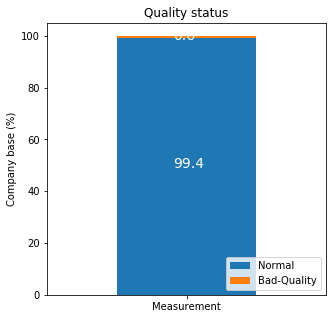

In [50]:
# Plot stacked bars
plot_stacked_bars(target_percentage.transpose(), "Quality status", (5, 5), legend_="lower right")

#### Ore grade distribution

In [52]:
df_target[[col for col in df_target if col.startswith('P85_')]].describe()

,P85_OPPA_FINES_30M,P85_OPPB_FINES_30M,P85_OPPC_FINES_30M,P85_OPPA_D50_30M,P85_OPPB_D50_30M,P85_OPPC_D50_30M,P85_OPPA_MB_30M,P85_OPPB_MB_30M,P85_OPPC_MB_30M,P85_OPPA_BPT_30M,P85_OPPB_BPT_30M,P85_OPPC_BPT_30M,P85_OPPA_CL,P85_OPPB_CL,P85_OPPC_CL
count,525890.000000,525889.000000,525890.000000,525890.000000,525890.000000,525890.000000,525889.000000,525890.000000,525889.000000,525890.000000,525889.000000,525890.000000,525890.000000,525867.000000,525872.000000
mean,12.619526,12.320374,12.679620,167.019938,166.433892,168.360912,150.653136,146.513783,155.551069,0.695674,0.687106,0.698059,85.919135,85.157189,84.955139
std,3.896666,3.894274,3.346908,31.611781,32.896790,25.896817,59.518946,59.791502,54.429001,0.102254,0.125445,0.088290,25.579382,24.499265,23.879496
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,9.956000,9.898623,10.201673,152.066125,150.709950,154.378475,109.160000,108.805000,117.780000,0.656132,0.659661,0.659840,69.666978,69.196890,68.887898
50%,12.301310,12.168890,12.433795,171.429700,170.955400,171.316100,144.500000,144.126650,147.974200,0.708167,0.706000,0.706280,81.516365,81.213810,80.561785
75%,14.664000,14.412000,14.995243,185.130000,185.358025,182.870000,180.195700,175.330050,185.338400,0.749891,0.749000,0.749419,99.174015,98.892950,98.431532
max,45.371000,46.009000,40.322540,348.810000,477.080000,355.580300,672.420000,575.406500,561.200000,8.654102,0.988000,9.558633,304.000000,387.263200,397.483700


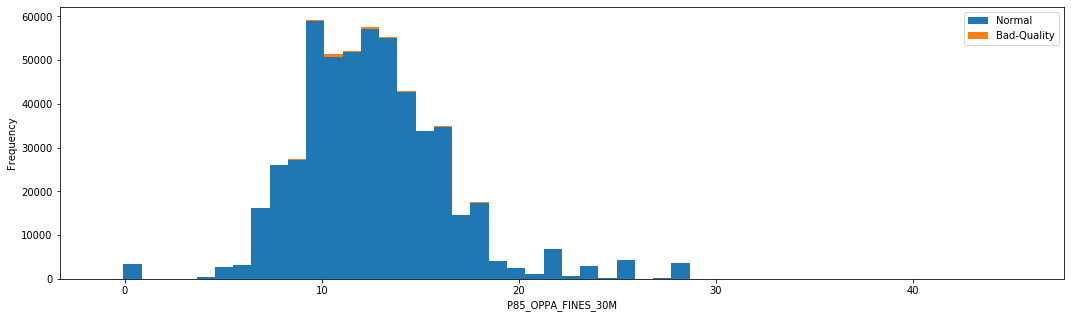

In [55]:
# Individual group distribution of electricity consumption
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, 'P85_OPPA_FINES_30M', target_tag_class=target_tag_class, ax=ax)

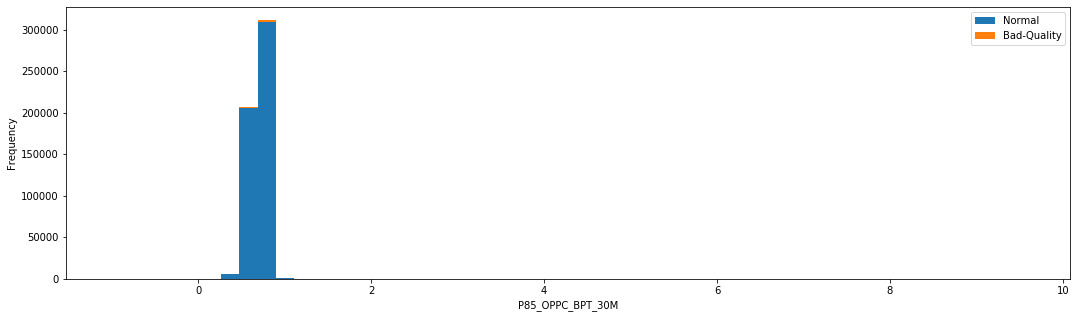

In [56]:
# Individual group distribution of electricity consumption
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, 'P85_OPPC_BPT_30M', target_tag_class=target_tag_class, ax=ax)

#### Tonnage rate distribution

In [58]:
df_target[[col for col in df_target if col.startswith('85WIC')]].describe()

,85WIC1703,85WIC2803,85WIC3803
count,522495.000000,525089.000000,525614.000000
mean,2681.885532,3327.900057,3179.174652
std,2335.452161,2279.107661,2349.496723
min,-2999.998000,0.000000,0.000000
25%,1.000009,1.000023,1.000023
50%,3611.328000,4400.844000,4269.328500
75%,4787.161000,5179.335000,5137.693250
max,12820.420000,51438.880000,52038.020000


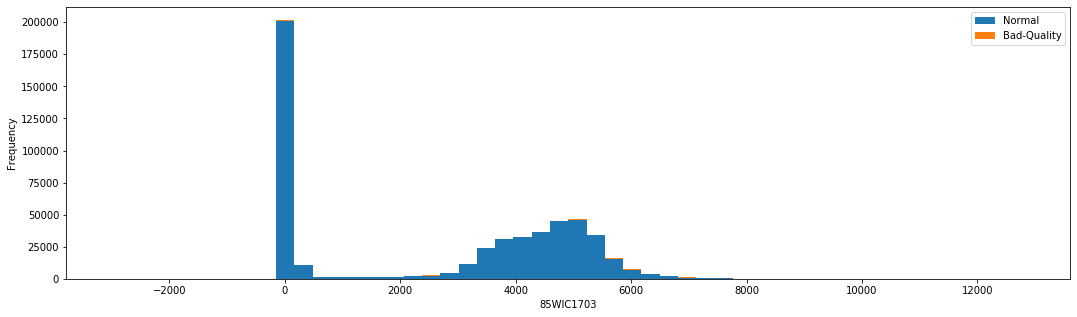

In [62]:
# Individual group distribution of electricity consumption
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '85WIC1703', target_tag_class=target_tag_class, ax=ax)

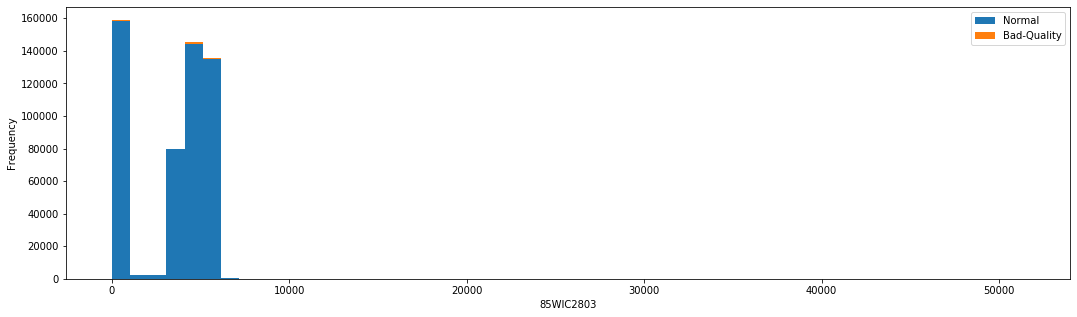

In [63]:
# Individual group distribution of electricity consumption
fig, ax = plt.subplots(figsize=(18,5))
plot_distribution(df_target, '85WIC2803', target_tag_class=target_tag_class, ax=ax)

## Data preprocessing
None of the operations in this step should "learn" anything from the data

In [11]:
# Set training and val times: 
train_start_time = '2017-01-01'
train_end_time = '2021-01-01'
valid_start_time = train_end_time
valid_end_time = '2022-01-01'

In [12]:
# Training and Validation dataset size
train_start = datetime.strptime(train_start_time, '%Y-%m-%d') 
train_end = datetime.strptime(train_end_time, '%Y-%m-%d') 

valid_start = datetime.strptime(valid_start_time, '%Y-%m-%d') 
valid_end = datetime.strptime(valid_end_time, '%Y-%m-%d') 

df_o.reset_index(inplace=True)

df_o.timestamp_utc = pd.to_datetime(df_o.timestamp_utc).apply(lambda x: x.replace(tzinfo=None))

# Train and Test split
train = df_o.loc[(df_o.timestamp_utc <= train_end_time) & (df_o.timestamp_utc >= train_start_time)]
valid = df_o.loc[(df_o.timestamp_utc <= valid_end_time) & (df_o.timestamp_utc >= valid_start_time)]

# we explicitly drop the training and testing data in the dead periods
trainDb = train.dropna()
# trainDb = trainDb[trainDb.target_label != -1]
validDb = valid.dropna()
# validDb = validDb[validDb.target_label != -1]

In [13]:
# Use this cell in development to save time.
# trainDb.to_csv(area+'trainDb.csv')
# validDb.to_csv(area+'validDb.csv')

# trainDb = pd.read_csv(area+'trainDb.csv')
# validDb = pd.read_csv(area+'validDb.csv')

In [14]:
# df_o.head()

In [15]:
# trainDb.set_index('timestamp_utc')

In [16]:
args = {'area': area, 
#         'mode': 'train', 
        'timestamp_column': 'timestamp_utc',
        'debug': True}
fq_fpp = models.quality.froth_quality.FrothQualityFeaturePreprocessor(args)

In [17]:
# importlib.reload(models.quality.froth_quality)

In [18]:
df_preprocess = fq_fpp.fit_transform(df_o)

area: MILLH2O, timestamp_column: timestamp_utc
Mode is train
area = MILLH2O
df_target.shape (3499, 1)
3499.0 episodes found
2017-01-01 12:00:00
data_grp_size: (51, 81)
2017-01-02 00:00:00
data_grp_size: (144, 81)
2017-01-03 00:00:00
data_grp_size: (144, 81)
2017-01-03 12:00:00
data_grp_size: (144, 81)
2017-01-04 00:00:00
data_grp_size: (144, 81)
2017-01-04 12:00:00
data_grp_size: (144, 81)
2017-01-05 00:00:00
data_grp_size: (144, 81)
2017-01-05 12:00:00
data_grp_size: (144, 81)
2017-01-06 00:00:00
data_grp_size: (144, 81)
2017-01-06 12:00:00
data_grp_size: (144, 81)
2017-01-07 00:00:00
data_grp_size: (144, 81)
2017-01-07 12:00:00
data_grp_size: (144, 81)
2017-01-08 00:00:00
data_grp_size: (144, 81)
2017-01-08 12:00:00
data_grp_size: (144, 81)
2017-01-09 00:00:00
data_grp_size: (144, 81)
2017-01-09 12:00:00
data_grp_size: (144, 81)
2017-01-10 00:00:00
data_grp_size: (144, 81)
2017-01-10 12:00:00
data_grp_size: (144, 81)
2017-01-11 00:00:00
data_grp_size: (144, 81)
2017-01-11 12:00:00
da

2017-04-15 11:00:00
data_grp_size: (144, 81)
2017-04-15 23:00:00
data_grp_size: (144, 81)
2017-04-16 11:00:00
data_grp_size: (144, 81)
2017-04-16 23:00:00
data_grp_size: (144, 81)
2017-04-17 11:00:00
data_grp_size: (144, 81)
2017-04-17 23:00:00
data_grp_size: (144, 81)
2017-04-18 11:00:00
data_grp_size: (144, 81)
2017-04-18 23:00:00
data_grp_size: (144, 81)
2017-04-19 11:00:00
data_grp_size: (144, 81)
2017-04-19 23:00:00
data_grp_size: (144, 81)
2017-04-20 11:00:00
data_grp_size: (144, 81)
2017-04-20 23:00:00
data_grp_size: (144, 81)
2017-04-21 11:00:00
data_grp_size: (144, 81)
2017-04-21 23:00:00
data_grp_size: (144, 81)
2017-04-22 11:00:00
data_grp_size: (144, 81)
2017-04-22 23:00:00
data_grp_size: (144, 81)
2017-04-23 11:00:00
data_grp_size: (144, 81)
2017-04-23 23:00:00
data_grp_size: (144, 81)
2017-04-24 11:00:00
data_grp_size: (144, 81)
2017-04-24 23:00:00
data_grp_size: (144, 81)
2017-04-25 11:00:00
data_grp_size: (144, 81)
2017-04-25 23:00:00
data_grp_size: (144, 81)
2017-04-26

2017-07-31 11:00:00
data_grp_size: (144, 81)
2017-07-31 23:00:00
data_grp_size: (144, 81)
2017-08-01 11:00:00
data_grp_size: (144, 81)
2017-08-01 23:00:00
data_grp_size: (144, 81)
2017-08-02 11:00:00
data_grp_size: (144, 81)
2017-08-02 23:00:00
data_grp_size: (144, 81)
2017-08-03 11:00:00
data_grp_size: (144, 81)
2017-08-03 23:00:00
data_grp_size: (144, 81)
2017-08-04 11:00:00
data_grp_size: (144, 81)
2017-08-04 23:00:00
data_grp_size: (144, 81)
2017-08-05 11:00:00
data_grp_size: (144, 81)
2017-08-06 23:00:00
data_grp_size: (144, 81)
2017-08-07 11:00:00
data_grp_size: (144, 81)
2017-08-07 23:00:00
data_grp_size: (144, 81)
2017-08-08 11:00:00
data_grp_size: (144, 81)
2017-08-08 23:00:00
data_grp_size: (144, 81)
2017-08-09 11:00:00
data_grp_size: (144, 81)
2017-08-09 23:00:00
data_grp_size: (144, 81)
2017-08-10 11:00:00
data_grp_size: (144, 81)
2017-08-10 23:00:00
data_grp_size: (144, 81)
2017-08-11 11:00:00
data_grp_size: (144, 81)
2017-08-11 23:00:00
data_grp_size: (144, 81)
2017-08-12

2017-11-12 00:00:00
data_grp_size: (144, 81)
2017-11-12 12:00:00
data_grp_size: (144, 81)
2017-11-13 00:00:00
data_grp_size: (144, 81)
2017-11-13 12:00:00
data_grp_size: (144, 81)
2017-11-14 00:00:00
data_grp_size: (144, 81)
2017-11-14 12:00:00
data_grp_size: (144, 81)
2017-11-15 00:00:00
data_grp_size: (144, 81)
2017-11-15 12:00:00
data_grp_size: (144, 81)
2017-11-16 00:00:00
data_grp_size: (144, 81)
2017-11-16 12:00:00
data_grp_size: (144, 81)
2017-11-17 00:00:00
data_grp_size: (144, 81)
2017-11-17 12:00:00
data_grp_size: (144, 81)
2017-11-18 00:00:00
data_grp_size: (144, 81)
2017-11-18 12:00:00
data_grp_size: (144, 81)
2017-11-19 00:00:00
data_grp_size: (144, 81)
2017-11-19 12:00:00
data_grp_size: (144, 81)
2017-11-20 12:00:00
data_grp_size: (144, 81)
2017-11-21 00:00:00
data_grp_size: (144, 81)
2017-11-21 12:00:00
data_grp_size: (144, 81)
2017-11-22 00:00:00
data_grp_size: (144, 81)
2017-11-22 12:00:00
data_grp_size: (144, 81)
2017-11-23 00:00:00
data_grp_size: (144, 81)
2017-11-23

2018-03-08 00:00:00
data_grp_size: (144, 81)
2018-03-08 12:00:00
data_grp_size: (144, 81)
2018-03-09 00:00:00
data_grp_size: (144, 81)
2018-03-09 12:00:00
data_grp_size: (144, 81)
2018-03-10 00:00:00
data_grp_size: (144, 81)
2018-03-10 12:00:00
data_grp_size: (144, 81)
2018-03-11 00:00:00
data_grp_size: (144, 81)
2018-03-11 11:00:00
data_grp_size: (144, 81)
2018-03-11 23:00:00
data_grp_size: (144, 81)
2018-03-12 11:00:00
data_grp_size: (144, 81)
2018-03-12 23:00:00
data_grp_size: (144, 81)
2018-03-13 11:00:00
data_grp_size: (144, 81)
2018-03-13 23:00:00
data_grp_size: (144, 81)
2018-03-14 11:00:00
data_grp_size: (144, 81)
2018-03-14 23:00:00
data_grp_size: (144, 81)
2018-03-15 11:00:00
data_grp_size: (144, 81)
2018-03-15 23:00:00
data_grp_size: (144, 81)
2018-03-16 11:00:00
data_grp_size: (144, 81)
2018-03-16 23:00:00
data_grp_size: (144, 81)
2018-03-17 11:00:00
data_grp_size: (144, 81)
2018-03-17 23:00:00
data_grp_size: (144, 81)
2018-03-18 11:00:00
data_grp_size: (144, 81)
2018-03-18

2018-06-21 11:00:00
data_grp_size: (144, 81)
2018-06-21 23:00:00
data_grp_size: (144, 81)
2018-06-22 11:00:00
data_grp_size: (144, 81)
2018-06-22 23:00:00
data_grp_size: (144, 81)
2018-06-23 11:00:00
data_grp_size: (144, 81)
2018-06-23 23:00:00
data_grp_size: (144, 81)
2018-06-24 11:00:00
data_grp_size: (144, 81)
2018-06-24 23:00:00
data_grp_size: (144, 81)
2018-06-25 11:00:00
data_grp_size: (144, 81)
2018-06-25 23:00:00
data_grp_size: (144, 81)
2018-06-26 11:00:00
data_grp_size: (144, 81)
2018-06-26 23:00:00
data_grp_size: (144, 81)
2018-06-27 11:00:00
data_grp_size: (144, 81)
2018-06-27 23:00:00
data_grp_size: (144, 81)
2018-06-28 11:00:00
data_grp_size: (144, 81)
2018-06-28 23:00:00
data_grp_size: (144, 81)
2018-06-29 11:00:00
data_grp_size: (144, 81)
2018-06-29 23:00:00
data_grp_size: (144, 81)
2018-06-30 11:00:00
data_grp_size: (144, 81)
2018-06-30 23:00:00
data_grp_size: (144, 81)
2018-07-01 11:00:00
data_grp_size: (144, 81)
2018-07-01 23:00:00
data_grp_size: (144, 81)
2018-07-02

2018-09-20 23:00:00
data_grp_size: (144, 81)
2018-09-21 11:00:00
data_grp_size: (144, 81)
2018-09-21 23:00:00
data_grp_size: (144, 81)
2018-09-22 11:00:00
data_grp_size: (144, 81)
2018-09-22 23:00:00
data_grp_size: (144, 81)
2018-09-23 11:00:00
data_grp_size: (144, 81)
2018-09-23 23:00:00
data_grp_size: (144, 81)
2018-09-24 11:00:00
data_grp_size: (144, 81)
2018-09-24 23:00:00
data_grp_size: (144, 81)
2018-09-25 11:00:00
data_grp_size: (144, 81)
2018-09-25 23:00:00
data_grp_size: (144, 81)
2018-09-26 11:00:00
data_grp_size: (144, 81)
2018-09-26 23:00:00
data_grp_size: (144, 81)
2018-09-27 11:00:00
data_grp_size: (144, 81)
2018-09-27 23:00:00
data_grp_size: (144, 81)
2018-09-28 11:00:00
data_grp_size: (144, 81)
2018-09-28 23:00:00
data_grp_size: (144, 81)
2018-09-29 11:00:00
data_grp_size: (144, 81)
2018-09-29 23:00:00
data_grp_size: (144, 81)
2018-09-30 11:00:00
data_grp_size: (144, 81)
2018-09-30 23:00:00
data_grp_size: (144, 81)
2018-10-01 11:00:00
data_grp_size: (144, 81)
2018-10-01

2018-12-29 00:00:00
data_grp_size: (144, 81)
2018-12-29 12:00:00
data_grp_size: (144, 81)
2018-12-30 00:00:00
data_grp_size: (144, 81)
2018-12-30 12:00:00
data_grp_size: (144, 81)
2018-12-31 00:00:00
data_grp_size: (144, 81)
2018-12-31 12:00:00
data_grp_size: (144, 81)
2019-01-01 00:00:00
data_grp_size: (144, 81)
2019-01-01 12:00:00
data_grp_size: (144, 81)
2019-01-02 00:00:00
data_grp_size: (144, 81)
2019-01-02 12:00:00
data_grp_size: (144, 81)
2019-01-03 00:00:00
data_grp_size: (144, 81)
2019-01-03 12:00:00
data_grp_size: (144, 81)
2019-01-04 00:00:00
data_grp_size: (144, 81)
2019-01-04 12:00:00
data_grp_size: (144, 81)
2019-01-05 00:00:00
data_grp_size: (144, 81)
2019-01-05 12:00:00
data_grp_size: (144, 81)
2019-01-06 00:00:00
data_grp_size: (144, 81)
2019-01-06 12:00:00
data_grp_size: (144, 81)
2019-01-07 00:00:00
data_grp_size: (144, 81)
2019-01-07 12:00:00
data_grp_size: (144, 81)
2019-01-08 00:00:00
data_grp_size: (144, 81)
2019-01-08 12:00:00
data_grp_size: (144, 81)
2019-01-09

2019-04-16 11:00:00
data_grp_size: (144, 81)
2019-04-16 23:00:00
data_grp_size: (144, 81)
2019-04-17 11:00:00
data_grp_size: (144, 81)
2019-04-17 23:00:00
data_grp_size: (144, 81)
2019-04-18 11:00:00
data_grp_size: (144, 81)
2019-04-18 23:00:00
data_grp_size: (144, 81)
2019-04-19 11:00:00
data_grp_size: (144, 81)
2019-04-19 23:00:00
data_grp_size: (144, 81)
2019-04-20 11:00:00
data_grp_size: (144, 81)
2019-04-20 23:00:00
data_grp_size: (144, 81)
2019-04-21 11:00:00
data_grp_size: (144, 81)
2019-04-21 23:00:00
data_grp_size: (144, 81)
2019-04-22 11:00:00
data_grp_size: (144, 81)
2019-04-22 23:00:00
data_grp_size: (144, 81)
2019-04-23 11:00:00
data_grp_size: (144, 81)
2019-04-23 23:00:00
data_grp_size: (144, 81)
2019-04-24 11:00:00
data_grp_size: (144, 81)
2019-04-24 23:00:00
data_grp_size: (144, 81)
2019-04-25 11:00:00
data_grp_size: (144, 81)
2019-04-25 23:00:00
data_grp_size: (144, 81)
2019-04-26 11:00:00
data_grp_size: (144, 81)
2019-04-26 23:00:00
data_grp_size: (144, 81)
2019-04-27

2019-07-28 11:00:00
data_grp_size: (144, 81)
2019-07-28 23:00:00
data_grp_size: (144, 81)
2019-07-29 11:00:00
data_grp_size: (144, 81)
2019-07-29 23:00:00
data_grp_size: (144, 81)
2019-07-30 11:00:00
data_grp_size: (144, 81)
2019-07-30 23:00:00
data_grp_size: (144, 81)
2019-07-31 11:00:00
data_grp_size: (144, 81)
2019-07-31 23:00:00
data_grp_size: (144, 81)
2019-08-01 11:00:00
data_grp_size: (144, 81)
2019-08-01 23:00:00
data_grp_size: (144, 81)
2019-08-02 11:00:00
data_grp_size: (144, 81)
2019-08-02 23:00:00
data_grp_size: (144, 81)
2019-08-03 11:00:00
data_grp_size: (144, 81)
2019-08-03 23:00:00
data_grp_size: (144, 81)
2019-08-04 11:00:00
data_grp_size: (144, 81)
2019-08-04 23:00:00
data_grp_size: (144, 81)
2019-08-05 11:00:00
data_grp_size: (144, 81)
2019-08-05 23:00:00
data_grp_size: (144, 81)
2019-08-06 11:00:00
data_grp_size: (144, 81)
2019-08-06 23:00:00
data_grp_size: (144, 81)
2019-08-07 11:00:00
data_grp_size: (144, 81)
2019-08-07 23:00:00
data_grp_size: (144, 81)
2019-08-08

2019-10-16 11:00:00
data_grp_size: (144, 81)
2019-10-16 23:00:00
data_grp_size: (144, 81)
2019-10-17 11:00:00
data_grp_size: (144, 81)
2019-10-17 23:00:00
data_grp_size: (144, 81)
2019-10-18 11:00:00
data_grp_size: (144, 81)
2019-10-18 23:00:00
data_grp_size: (144, 81)
2019-10-19 11:00:00
data_grp_size: (144, 81)
2019-10-19 23:00:00
data_grp_size: (144, 81)
2019-10-20 11:00:00
data_grp_size: (144, 81)
2019-10-20 23:00:00
data_grp_size: (144, 81)
2019-10-21 11:00:00
data_grp_size: (144, 81)
2019-10-21 23:00:00
data_grp_size: (144, 81)
2019-10-22 11:00:00
data_grp_size: (144, 81)
2019-10-22 23:00:00
data_grp_size: (144, 81)
2019-10-23 11:00:00
data_grp_size: (144, 81)
2019-10-23 23:00:00
data_grp_size: (144, 81)
2019-10-24 11:00:00
data_grp_size: (144, 81)
2019-10-24 23:00:00
data_grp_size: (144, 81)
2019-10-25 11:00:00
data_grp_size: (144, 81)
2019-10-25 23:00:00
data_grp_size: (144, 81)
2019-10-26 11:00:00
data_grp_size: (144, 81)
2019-10-26 23:00:00
data_grp_size: (144, 81)
2019-10-27

2019-12-30 00:00:00
data_grp_size: (144, 81)
2019-12-30 06:00:00
data_grp_size: (144, 81)
2019-12-30 18:00:00
data_grp_size: (144, 81)
2019-12-31 00:00:00
data_grp_size: (144, 81)
2019-12-31 06:00:00
data_grp_size: (144, 81)
2019-12-31 12:00:00
data_grp_size: (144, 81)
2019-12-31 18:00:00
data_grp_size: (144, 81)
2020-01-01 06:00:00
data_grp_size: (144, 81)
2020-01-01 18:00:00
data_grp_size: (144, 81)
2020-01-02 06:00:00
data_grp_size: (144, 81)
2020-01-02 18:00:00
data_grp_size: (144, 81)
2020-01-03 00:00:00
data_grp_size: (144, 81)
2020-01-03 12:00:00
data_grp_size: (144, 81)
2020-01-04 00:00:00
data_grp_size: (144, 81)
2020-01-04 12:00:00
data_grp_size: (144, 81)
2020-01-05 00:00:00
data_grp_size: (144, 81)
2020-01-05 12:00:00
data_grp_size: (144, 81)
2020-01-06 00:00:00
data_grp_size: (144, 81)
2020-01-06 12:00:00
data_grp_size: (144, 81)
2020-01-07 00:00:00
data_grp_size: (144, 81)
2020-01-07 12:00:00
data_grp_size: (144, 81)
2020-01-08 00:00:00
data_grp_size: (144, 81)
2020-01-08

2020-04-04 23:00:00
data_grp_size: (144, 81)
2020-04-05 11:00:00
data_grp_size: (144, 81)
2020-04-05 23:00:00
data_grp_size: (144, 81)
2020-04-06 11:00:00
data_grp_size: (144, 81)
2020-04-06 23:00:00
data_grp_size: (144, 81)
2020-04-07 11:00:00
data_grp_size: (144, 81)
2020-04-07 23:00:00
data_grp_size: (144, 81)
2020-04-08 11:00:00
data_grp_size: (144, 81)
2020-04-08 23:00:00
data_grp_size: (144, 81)
2020-04-09 11:00:00
data_grp_size: (144, 81)
2020-04-09 23:00:00
data_grp_size: (144, 81)
2020-04-10 11:00:00
data_grp_size: (144, 81)
2020-04-10 23:00:00
data_grp_size: (144, 81)
2020-04-11 11:00:00
data_grp_size: (144, 81)
2020-04-11 23:00:00
data_grp_size: (144, 81)
2020-04-12 11:00:00
data_grp_size: (144, 81)
2020-04-12 23:00:00
data_grp_size: (144, 81)
2020-04-13 11:00:00
data_grp_size: (144, 81)
2020-04-13 23:00:00
data_grp_size: (144, 81)
2020-04-14 11:00:00
data_grp_size: (144, 81)
2020-04-14 23:00:00
data_grp_size: (144, 81)
2020-04-15 11:00:00
data_grp_size: (144, 81)
2020-04-15

2020-07-15 23:00:00
data_grp_size: (144, 81)
2020-07-16 11:00:00
data_grp_size: (144, 81)
2020-07-16 23:00:00
data_grp_size: (144, 81)
2020-07-17 11:00:00
data_grp_size: (144, 81)
2020-07-18 23:00:00
data_grp_size: (144, 81)
2020-07-19 11:00:00
data_grp_size: (144, 81)
2020-07-19 23:00:00
data_grp_size: (144, 81)
2020-07-20 11:00:00
data_grp_size: (144, 81)
2020-07-20 23:00:00
data_grp_size: (144, 81)
2020-07-21 11:00:00
data_grp_size: (144, 81)
2020-07-21 23:00:00
data_grp_size: (144, 81)
2020-07-22 11:00:00
data_grp_size: (144, 81)
2020-07-22 23:00:00
data_grp_size: (144, 81)
2020-07-23 11:00:00
data_grp_size: (144, 81)
2020-07-23 23:00:00
data_grp_size: (144, 81)
2020-07-24 11:00:00
data_grp_size: (144, 81)
2020-07-24 23:00:00
data_grp_size: (144, 81)
2020-07-25 11:00:00
data_grp_size: (144, 81)
2020-07-25 23:00:00
data_grp_size: (144, 81)
2020-07-26 11:00:00
data_grp_size: (144, 81)
2020-07-26 23:00:00
data_grp_size: (144, 81)
2020-07-27 11:00:00
data_grp_size: (144, 81)
2020-07-27

2020-11-12 00:00:00
data_grp_size: (144, 81)
2020-11-12 12:00:00
data_grp_size: (144, 81)
2020-11-13 00:00:00
data_grp_size: (144, 81)
2020-11-13 12:00:00
data_grp_size: (144, 81)
2020-11-14 00:00:00
data_grp_size: (144, 81)
2020-11-14 12:00:00
data_grp_size: (144, 81)
2020-11-15 00:00:00
data_grp_size: (144, 81)
2020-11-15 12:00:00
data_grp_size: (144, 81)
2020-11-16 00:00:00
data_grp_size: (144, 81)
2020-11-16 12:00:00
data_grp_size: (144, 81)
2020-11-17 00:00:00
data_grp_size: (144, 81)
2020-11-17 12:00:00
data_grp_size: (144, 81)
2020-11-18 00:00:00
data_grp_size: (144, 81)
2020-11-18 12:00:00
data_grp_size: (144, 81)
2020-11-19 00:00:00
data_grp_size: (144, 81)
2020-11-19 12:00:00
data_grp_size: (144, 81)
2020-11-20 00:00:00
data_grp_size: (144, 81)
2020-11-20 12:00:00
data_grp_size: (144, 81)
2020-11-21 00:00:00
data_grp_size: (144, 81)
2020-11-21 12:00:00
data_grp_size: (144, 81)
2020-11-22 00:00:00
data_grp_size: (144, 81)
2020-11-22 12:00:00
data_grp_size: (144, 81)
2020-11-23

2021-02-16 00:00:00
data_grp_size: (144, 81)
2021-02-16 12:00:00
data_grp_size: (144, 81)
2021-02-17 00:00:00
data_grp_size: (144, 81)
2021-02-17 18:00:00
data_grp_size: (144, 81)
2021-02-18 06:00:00
data_grp_size: (144, 81)
2021-02-18 18:00:00
data_grp_size: (144, 81)
2021-02-19 06:00:00
data_grp_size: (144, 81)
2021-02-19 18:00:00
data_grp_size: (144, 81)
2021-02-20 06:00:00
data_grp_size: (144, 81)
2021-02-20 18:00:00
data_grp_size: (144, 81)
2021-02-21 06:00:00
data_grp_size: (144, 81)
2021-02-21 18:00:00
data_grp_size: (144, 81)
2021-02-22 06:00:00
data_grp_size: (144, 81)
2021-02-22 11:00:00
data_grp_size: (144, 81)
2021-02-22 18:00:00
data_grp_size: (144, 81)
2021-02-22 23:00:00
data_grp_size: (144, 81)
2021-02-23 06:00:00
data_grp_size: (144, 81)
2021-02-23 11:00:00
data_grp_size: (144, 81)
2021-02-23 18:00:00
data_grp_size: (144, 81)
2021-02-23 23:00:00
data_grp_size: (144, 81)
2021-02-24 06:00:00
data_grp_size: (144, 81)
2021-02-24 11:00:00
data_grp_size: (144, 81)
2021-02-24

2021-05-20 23:00:00
data_grp_size: (144, 81)
2021-05-21 11:00:00
data_grp_size: (144, 81)
2021-05-21 23:00:00
data_grp_size: (144, 81)
2021-05-22 11:00:00
data_grp_size: (144, 81)
2021-05-22 23:00:00
data_grp_size: (144, 81)
2021-05-23 11:00:00
data_grp_size: (144, 81)
2021-05-23 23:00:00
data_grp_size: (144, 81)
2021-05-24 11:00:00
data_grp_size: (144, 81)
2021-05-24 23:00:00
data_grp_size: (144, 81)
2021-05-25 11:00:00
data_grp_size: (144, 81)
2021-05-25 23:00:00
data_grp_size: (144, 81)
2021-05-26 11:00:00
data_grp_size: (144, 81)
2021-05-26 23:00:00
data_grp_size: (144, 81)
2021-05-27 11:00:00
data_grp_size: (144, 81)
2021-05-27 23:00:00
data_grp_size: (144, 81)
2021-05-28 11:00:00
data_grp_size: (144, 81)
2021-05-28 23:00:00
data_grp_size: (144, 81)
2021-05-29 11:00:00
data_grp_size: (144, 81)
2021-05-29 23:00:00
data_grp_size: (144, 81)
2021-05-30 11:00:00
data_grp_size: (144, 81)
2021-05-30 23:00:00
data_grp_size: (144, 81)
2021-05-31 11:00:00
data_grp_size: (144, 81)
2021-05-31

2021-09-30 11:00:00
data_grp_size: (144, 81)
2021-09-30 23:00:00
data_grp_size: (144, 81)
2021-10-01 11:00:00
data_grp_size: (144, 81)
2021-10-01 23:00:00
data_grp_size: (144, 81)
2021-10-02 11:00:00
data_grp_size: (144, 81)
2021-10-02 23:00:00
data_grp_size: (144, 81)
2021-10-03 11:00:00
data_grp_size: (144, 81)
2021-10-03 23:00:00
data_grp_size: (144, 81)
2021-10-04 11:00:00
data_grp_size: (144, 81)
2021-10-04 23:00:00
data_grp_size: (144, 81)
2021-10-05 11:00:00
data_grp_size: (144, 81)
2021-10-05 23:00:00
data_grp_size: (144, 81)
2021-10-06 11:00:00
data_grp_size: (144, 81)
2021-10-06 23:00:00
data_grp_size: (144, 81)
2021-10-07 11:00:00
data_grp_size: (144, 81)
2021-10-07 23:00:00
data_grp_size: (144, 81)
2021-10-08 11:00:00
data_grp_size: (144, 81)
2021-10-08 23:00:00
data_grp_size: (144, 81)
2021-10-09 11:00:00
data_grp_size: (144, 81)
2021-10-09 23:00:00
data_grp_size: (144, 81)
2021-10-10 11:00:00
data_grp_size: (144, 81)
2021-10-10 23:00:00
data_grp_size: (144, 81)
2021-10-11

2022-01-01 00:00:00
data_grp_size: (144, 81)
2022-01-01 07:00:00
data_grp_size: (144, 81)


Feature Extraction: 100%|████████████████████████████████████████████████████| 242350/242350 [01:48<00:00, 2241.87it/s]


In [19]:
df_preprocess

,MILL_FROTH_PROD__sum_values,MILL_FROTH_PROD__median,MILL_FROTH_PROD__mean,MILL_FROTH_PROD__standard_deviation,MILL_FROTH_PROD__variance,MILL_FROTH_PROD__maximum,MILL_FROTH_PROD__minimum,MILL_OILSAND_MASS__sum_values,MILL_OILSAND_MASS__median,MILL_OILSAND_MASS__mean,...,P86_FROTH_WATER_prev_class,target,DR_1,DR_2,DR_3,DR_4,DR_1_prev,DR_2_prev,DR_3_prev,DR_4_prev
timestamp_utc,,,,,,,,,,,,,,,,,,,,,
2017-01-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02 00:00:00,110610.3323,750.80300,768.127308,158.802443,25218.216017,1435.7720,431.8512,7.709013e+05,5426.8390,5353.481035,...,1.0,0.0,-23.142947,-11.004016,-11.062469,-6.939183,NaN,NaN,NaN,NaN
2017-01-03 00:00:00,124357.6356,850.86565,863.594692,214.178302,45872.344915,1495.4810,376.2102,7.761789e+05,5401.7240,5390.131590,...,0.0,0.0,78.348200,15.336043,-1.777764,-7.967627,-23.142947,-11.004016,-11.062469,-6.939183
2017-01-03 12:00:00,122865.6648,829.17245,853.233783,224.957830,50606.025253,1530.8350,314.0785,7.531230e+05,5203.3690,5230.020715,...,0.0,0.0,53.710555,-7.720792,-6.779277,-6.721920,78.348200,15.336043,-1.777764,-7.967627
2017-01-04 00:00:00,217718.5015,1515.37050,1511.934038,264.456011,69936.981994,2462.8380,838.4552,1.454918e+06,10160.1450,10103.594354,...,0.0,0.0,-13.882594,-10.193173,-11.741446,-7.676390,53.710555,-7.720792,-6.779277,-6.721920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 12:00:00,147238.6731,1040.93600,1022.490785,507.133115,257183.996159,2527.6490,291.0184,1.013226e+06,6588.2170,7036.290917,...,0.0,0.0,-15.814278,-5.939691,15.085505,2.189527,-12.267094,-11.981422,-0.342589,-9.291833
2021-12-31 00:00:00,73236.5620,463.73030,508.587236,196.923217,38778.753561,935.8768,265.6259,5.891375e+05,4252.1225,4091.232501,...,0.0,0.0,-16.003145,15.076466,9.900814,13.173543,-15.814278,-5.939691,15.085505,2.189527
2021-12-31 12:00:00,134384.8761,874.96950,933.228306,234.180668,54840.585288,1765.1270,523.0626,8.480329e+05,5183.7420,5889.117583,...,0.0,1.0,1.976872,-11.653824,1.377253,4.407611,-16.003145,15.076466,9.900814,13.173543


In [20]:
cols = fq_fpp.trained_params['final_columns']

train_start = datetime.strptime(train_start_time, '%Y-%m-%d') 
train_end = datetime.strptime(train_end_time, '%Y-%m-%d') 

valid_start = datetime.strptime(valid_start_time, '%Y-%m-%d') 
valid_end = datetime.strptime(valid_end_time, '%Y-%m-%d') 

# df_o.reset_index(inplace=True)
# df_preprocess['timestamp_utc'] = pd.to_datetime(df_preprocess['timestamp_utc']).apply(lambda x: x.replace(tzinfo=None))

df_preprocess.dropna(inplace=True)
# Train and Test split
train = df_preprocess.loc[train_start_time:train_end_time]
valid = df_preprocess.loc[valid_start_time:valid_end_time]

#Drop datatime

train.reset_index(inplace=True)
train_filt = train[train[target_tag]>train[target_tag].quantile(0.4)] #Drop low values of froth quality to focus on the area near excursion
X_train = train_filt.copy()
y_train = train_filt['target']

valid.reset_index(inplace=True)
X_valid = valid.copy()
y_valid = valid['target']



## Create overall pipeline based on training experiments

In [21]:
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion, Pipeline
# from srom.feature_selection.feature_selection import FeatureListSelector, FeatureListDropper
from models.quality.froth_quality_features import FeatureListSelector, ImbClassifier,ImbRandomForestClassifier,ImbExtraTreesClassifier,ImbGradientBoostingClassifier,ImbXGBClassifier,ImbMLPClassifier,NoTransform,NoSelect

In [22]:
# These features were selected during the model development process

feature_list = ['ORE_AGG_SUM__mean',
     'TAILS_FLOW_AGG_SUM__sum_values',
     '86TIC209__sum_values',
     'MB_AGG_SUM__sum_values',
     'D50_AGG_SUM__maximum',
     'TAILS_FLOW_AGG_SUM__maximum',
     'oppa_cl_x_tonnage__minimum',
     'TotalFlowrate__maximum',
     'oppb_bpt_x_tonnage__sum_values',
     '85DI2661__mean',
     '86TI188__minimum',
     '85TI2663__minimum',
     'CL_AGG_SUM__maximum',
     'Low density_mean__standard_deviation',
     '85TI1663__variance',
     '85TI3663__standard_deviation',
     'BPT_AGG_MAX__mean',
     'D50_AGG_MAX__sum_values',
     'DR_3']

final_selection = Pipeline([('feature list', FeatureListSelector(feature_list))])


In [23]:
base_config_dict = {

    # Classifiers
    'sklearn.ensemble.ExtraTreesClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf':  range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.GradientBoostingClassifier': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05)
    },

    'xgboost.XGBClassifier': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'nthread': [-2]
    },

    'sklearn.neural_network.MLPClassifier': {
        'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
        'learning_rate_init': [1e-3, 1e-2, 1e-1, 0.5, 1.]
    },

    # Preprocesssors
    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },
    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },
    '__main__.NoTransform': {
    },

    # Selectors
    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_classif': None
        }
    },
    '__main__.NoSelect': {
    }
}

In [24]:
imb_config_dict = {

#     # Classifiers
#     'sklearn.ensemble.ExtraTreesClassifier': {
#         'n_estimators': [100],
#         'criterion': ["gini", "entropy"],
#         'max_features': np.arange(0.05, 1.01, 0.05),
#         'min_samples_split': range(2, 21),
#         'min_samples_leaf': range(1, 21),
#         'bootstrap': [True, False]
#     },

#     'sklearn.ensemble.RandomForestClassifier': {
#         'n_estimators': [100],
#         'criterion': ["gini", "entropy"],
#         'max_features': np.arange(0.05, 1.01, 0.05),
#         'min_samples_split': range(2, 21),
#         'min_samples_leaf':  range(1, 21),
#         'bootstrap': [True, False]
#     },

#     'sklearn.ensemble.GradientBoostingClassifier': {
#         'n_estimators': [100],
#         'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
#         'max_depth': range(1, 11),
#         'min_samples_split': range(2, 21),
#         'min_samples_leaf': range(1, 21),
#         'subsample': np.arange(0.05, 1.01, 0.05),
#         'max_features': np.arange(0.05, 1.01, 0.05)
#     },

#     'xgboost.XGBClassifier': {
#         'n_estimators': [100],
#         'max_depth': range(1, 11),
#         'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
#         'subsample': np.arange(0.05, 1.01, 0.05),
#         'min_child_weight': range(1, 21),
#         'nthread': [-2]
#     },

#     'sklearn.neural_network.MLPClassifier': {
#         'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
#         'learning_rate_init': [1e-3, 1e-2, 1e-1, 0.5, 1.]
#     },

    '__main__.ImbExtraTreesClassifier': {
        'base_model__n_estimators': [100],
        'base_model__criterion': ["gini", "entropy"],
        'base_model__max_features': np.arange(0.05, 1.01, 0.05),
        'base_model__min_samples_split': range(2, 21),
        'base_model__min_samples_leaf': range(1, 21),
        'base_model__bootstrap': [True, False]
    },

    '__main__.ImbRandomForestClassifier': {
        'base_model__n_estimators': [100],
        'base_model__criterion': ["gini", "entropy"],
        'base_model__max_features': np.arange(0.05, 1.01, 0.05),
        'base_model__min_samples_split': range(2, 21),
        'base_model__min_samples_leaf':  range(1, 21),
        'base_model__bootstrap': [True, False]
    },

    '__main__.ImbGradientBoostingClassifier': {
        'base_model__n_estimators': [100],
        'base_model__learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'base_model__max_depth': range(1, 11),
        'base_model__min_samples_split': range(2, 21),
        'base_model__min_samples_leaf': range(1, 21),
        'base_model__subsample': np.arange(0.05, 1.01, 0.05),
        'base_model__max_features': np.arange(0.05, 1.01, 0.05)
    },

    '__main__.ImbXGBClassifier': {
        'base_model__n_estimators': [100],
        'base_model__max_depth': range(1, 11),
        'base_model__learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'base_model__subsample': np.arange(0.05, 1.01, 0.05),
        'base_model__min_child_weight': range(1, 21),
        'base_model__nthread': [-2]
    },

    '__main__.ImbMLPClassifier': {
        'base_model__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
        'base_model__learning_rate_init': [1e-3, 1e-2, 1e-1, 0.5, 1.]
    },

    # Preprocesssors
    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },
    'sklearn.preprocessing.RobustScaler': {
    },
    'sklearn.preprocessing.StandardScaler': {
    },
    '__main__.NoTransform': {
    },

    # Selectors
    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_classif': None
        }
    },
    '__main__.NoSelect': {
    }
}

In [25]:
#Custom scoring function
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
average_precision = make_scorer(average_precision_score, greater_is_better=True)

In [26]:
# Uncomment when you need to run TPOT
# from tpot import TPOTClassifier
# tpot = TPOTClassifier(generations=10, population_size=50, verbosity=3, config_dict = imb_config_dict, scoring= average_precision, 
#                       random_state=42, n_jobs=-2, template='Selector-Transformer-Classifier')# Try doing 5 classifiers?


In [27]:
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

if use_final_model:
    pipe = Pipeline([('feature selection', final_selection),
        ('imbrf', ImbClassifier(base_model=RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features=0.1,
            max_leaf_nodes=None, min_impurity_decrease=0.00175,
            min_samples_leaf=15,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False), base_sampler = RandomUnderSampler()))
    ])
    
# else:
#     tpot.fit(X, y)
#     pipe=tpot.fitted_pipeline_   

In [28]:
np.random.seed(7)

In [29]:
## additional training/testing and performance evaluation here

In [30]:
train_model = clone(pipe)
train_model.fit(X_train, y_train)

Pipeline(steps=[('feature selection',
                 Pipeline(steps=[('feature list',
                                  FeatureListSelector(feature_list=['ORE_AGG_SUM__mean',
                                                                    'TAILS_FLOW_AGG_SUM__sum_values',
                                                                    '86TIC209__sum_values',
                                                                    'MB_AGG_SUM__sum_values',
                                                                    'D50_AGG_SUM__maximum',
                                                                    'TAILS_FLOW_AGG_SUM__maximum',
                                                                    'oppa_cl_x_tonnage__minimum',
                                                                    'TotalFlowrate__maximum',
                                                                    'oppb_bpt_x_tonnage__sum_values',
                                                  

In [32]:
from useful import plot_data
import bokeh

bokeh.io.reset_output()
bokeh.io.output_notebook()

plot_dict = {}
plot_dict['Preds and target'] = {}
plot_dict['Preds and target']['tags_to_plot'] = ['process_upset', 'prob_failure']

plot_tabs = {}
plot_tabs['tab1'] = ['Preds and target']

plot_data(validDb, plot_dict, plot_tabs, 'timestamp_utc', end_date='2021-01-01', savefile='P53_predictions.html')

ModuleNotFoundError: No module named 'useful'

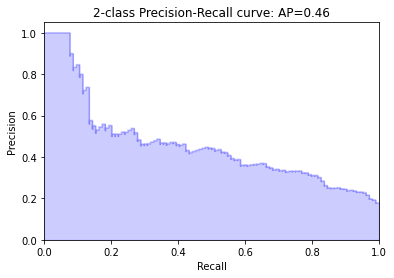

In [33]:
from sklearn.metrics import confusion_matrix, f1_score
from inspect import signature

#Use the model performance dict to select a threshold based on Site Wide Lead feedback
y_proba = train_model.predict_proba(X_valid)
average_precision = average_precision_score(y_valid, y_proba[:,1])
precision, recall, thres = precision_recall_curve(y_valid, y_proba[:,1])

model_performance_dict = {}
val_proba = y_proba[:,1]

for item in zip(precision, recall, thres):
    val_pred =  (val_proba > item[2]) * 1
    f1 = f1_score(y_valid, val_pred)
    _, false_alarm, _, hit = confusion_matrix(y_valid, val_pred).ravel()
    
    # model_performance_dict[threshold] = [precision, recall, false alarm count, hit count]
    model_performance_dict[item[2]] = [item[0], item[1], f1, false_alarm, hit]

### Plot the model performance ###
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.savefig('{}.png'.format(area))
plt.show()


### Write out performance metrics for different model thresholds ###
# for key, value in model_performance_dict.items():
#     print('Threshold:%.2f, Prec:%.2f, Recall:%.2f, F1:%.2f, False alarms:%d, Hit count:%d'%(key, value[0], value[1], value[2], value[3], value[4]))


In [34]:
validDb = valid.copy()
# validDb['pred'] = valid_y_pred
validDb['prob_failure']=[el[1]*100 for el in y_proba]
# validDb['pred2']=(validDb['prob_failure']>0.70)*1.0
validDb['process_upset']=(validDb['P86_FROTH_WATER']>30)*100.0

In [35]:
## Write out best f1 score ##
max_f1 = 0
for key, value in model_performance_dict.items():
    if value[2] > max_f1:
        thres = key
        prec = value[0]
        rec = value[1]
        max_f1 = value[2]
        false_alarms = value[3]
        hit_count = value[4]

print('Threshold: {}, Prec: {}, Recall: {}, F1: {}, False alarms: {}, Hit count: {}'.format(thres, prec, rec, max_f1, false_alarms, hit_count))

Threshold: 0.5691304625910801, Prec: 0.4330708661417323, Recall: 0.5288461538461539, F1: 0.4782608695652174, False alarms: 71, Hit count: 55


**Onset_button**

In [122]:
## The following function leverage the onset button
def onset(onset_window, threshold, y_pred_prob, y_true):
    '''This function leverage the onset button for the post-processing where it 
    describe the amount of time a rule should be violated before the flag turns on
    
    Parameters:
    onset_window: the amount of time a rule should be violated before actual flagging;
    threshold: the threshold decided to judge whether flagging or not;
    y_pre_prob: predicted probability;
    y_true: truth of flagging; '''
    
    # Get the y_pred under threshold
    y_pred = (y_pred_prob>threshold)*1.0
    
    # Find the event_start_index
    diff = np.diff(y_pred)
    event_start = np.hstack([0, diff==1])
    # Add the first value as it is
    if y_pred[0] == 1:
        event_start[0] = 1
    event_start_index = np.where(event_start==1)[0]
    
    # Find the onset_start_index
    onset_start_index = event_start_index + int(onset_window/5)
    
    # Case when the onset_start_index exceeding the total length
    onset_start_index = np.delete(onset_start_index, onset_start_index >= len(y_pred))
    num_to_append = len(event_start_index) - len(onset_start_index)
    onset_start_index = np.hstack([onset_start_index, np.ones(num_to_append)*len(y_pred)]).astype(int)
    
    # Remove the flagging during onset_window(event_start_index, onset_start_index)
    for i in range(len(event_start_index)):
        y_pred[event_start_index[i]:onset_start_index[i]] = 0
    
    # Return the post-processed y_pred
    return y_pred

**Offset_button**

In [123]:
## The following function leverage the offset button
def offset(offset_window, y_pred, y_true):
    '''This function leverage the offset button for the post-processing where it 
    describe the amount of time a rule should be violated before the flag turns off
    
    Parameters:
    offset_window: the amount of time a rule should be violated before flag turns off;
    y_pred: predicted value;
    y_true: truth of flagging; '''
    
    # Find the event_end_index
    diff = np.diff(y_pred)
    event_end = np.hstack([diff==-1, 0])
    # Add the last value as it is
    if y_pred[-1] == 1:
        event_end[-1] = 1
    event_end_index = np.where(event_end==1)[0]
    
    # Find the offset_end_index
    offset_end_index = event_end_index + int(offset_window/5)
    
    # Case when the offset_end_index exceeding the total length
    offset_end_index = np.delete(offset_end_index, offset_end_index >= len(y_pred))
    num_to_append = len(event_end_index) - len(offset_end_index)
    offset_end_index = np.hstack([offset_end_index, np.ones(num_to_append)*len(y_pred)]).astype(int)
    
    # Add flagging during onset_window(event_start_index, onset_start_index)
    for i in range(len(event_end_index)):
        y_pred[event_end_index[i]:offset_end_index[i]] = 1
    
    # Return the post-processed y_pred
    return y_pred
    

In [131]:
# Post processing
thre = 0.56
y_pred_test = onset(10, thre, y_proba[:,1], y_valid)
y_pred_test = offset(30, y_pred_test, y_valid)

# Calculate precision and recall rate under thre and after post-processing
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
print('Precision rate after post-processing %.2f'%(precision_score(y_valid, y_pred_test)))
print('Recall rate after post-processing %.2f'%(recall_score(y_valid, y_pred_test)))

# Calculate precision and recall rate under thre and before post-processing
print('Precision rate before post-processing %.2f'%(precision_score(y_valid, y_proba[:,1]> thre)))
print('Recall rate before post-processing %.2f'%(recall_score(y_valid, y_proba[:,1]> thre)))

Precision rate after post-processing 0.36
Recall rate after post-processing 0.42
Precision rate before post-processing 0.40
Recall rate before post-processing 0.55


**Save the results**
1. the plot of the precision-recall curve
2. the corresponding precision and recall value at different threshold
3. the best precision and recall set

In [37]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from inspect import signature

def save_perf_results(trained_model, valid_y, valid_X, pin, area='Model Performance Track/Others/'):
    '''The function save the performance of the model, it will save the precision recall curve,
    model_performance_dict with precision and recall at various thresholds, and precision recall set at best f1score
    
    Inputs:
        trained_model: the trained model
        valid_y: true y
        valid_X: X value to be predicted
        pin: specified precision rate as milestone for best suit
        area: path of the saved results
    
    Outputs:
        precision_recall curve
        precision recall sets
        best precision recall suit selected by max f1 and pin value
    '''
    def calculate_f1(x):
        pred_y_examined = (pred_y > x[0]) * 1
        f1 = f1_score(valid_y, pred_y_examined)
        return f1
    
    ## predict
    pred_y = trained_model.predict_proba(valid_X)[:,1]
    
    ## evaluation
    precision, recall, thres = precision_recall_curve(valid_y, pred_y)
    
    ## put evaluated results into df
    thres = thres.tolist()
    thres.insert(0,0)
    result_dict = {'Precision': precision, 'Recall':recall, 'Threshold':thres}
    result_df = pd.DataFrame(result_dict)
    # round the result
    result_df[['Precision','Recall']] = result_df[['Precision','Recall']].apply(lambda x: round(x, 2))
    result_df['Threshold'] = result_df['Threshold'].apply(lambda x: round(x, 3))
    # groupby to get desired set
    groupby_thr_df = result_df.groupby('Threshold')[['Precision', 'Recall']].agg(['mean']).reset_index()
    groupby_thr_df.columns = ['Threshold', 'Precision', 'Recall']
    # round again
    groupby_thr_df[['Precision','Recall']] = groupby_thr_df[['Precision','Recall']].apply(lambda x: round(x, 2))
    
    ## plot and save fig
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.savefig('{}.png'.format(area))
    plt.show()
    
    ## best suit selected by specified value
    groupby_thr_df.loc['Best suit selected by specified precision'] = groupby_thr_df.loc[groupby_thr_df['Precision'] >= pin].iloc[0]
    
    ## best suit selected by max F1
    groupby_thr_df['F1'] = groupby_thr_df.apply(calculate_f1, axis=1)
    groupby_thr_df['F1'] = groupby_thr_df['F1'].apply(lambda x: round(x, 3))
    groupby_thr_df.loc['Best suit selected by F1'] = groupby_thr_df.loc[groupby_thr_df['F1']== groupby_thr_df['F1'].max()].iloc[0]
            
    ## save the results
    groupby_thr_df.to_excel('{}.xlsx'.format(area))
    
    return 

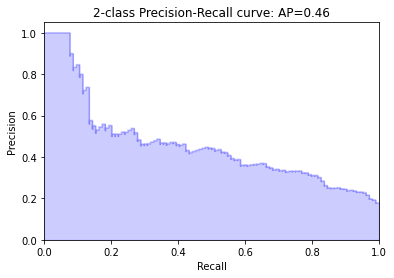

In [38]:
save_perf_results(train_model, y_valid, X_valid, pin=0.3, area='Model Performance Track/Quality Model/MILLH2O')

## Deployment preparation

1. Train final model
1. Save trained model as pickle file
1. Save supporting params/data needed in JSON file

Inputs:
1. Model save directory

In [35]:
final_model = clone(pipe)

finalDb = pd.concat([X_train, X_valid], ignore_index=True)
finalTarget = pd.concat([y_train, y_valid], ignore_index=True)

X = finalDb
y = finalTarget

final_model.fit(X, y)

# pickle.dump(final_model, open(area+'_final.pkl', 'wb'))

Pipeline(steps=[('feature selection',
                 Pipeline(steps=[('feature list',
                                  FeatureListSelector(feature_list=['ORE_AGG_SUM__mean',
                                                                    'TAILS_FLOW_AGG_SUM__sum_values',
                                                                    '86TIC209__sum_values',
                                                                    'MB_AGG_SUM__sum_values',
                                                                    'D50_AGG_SUM__maximum',
                                                                    'TAILS_FLOW_AGG_SUM__maximum',
                                                                    'oppa_cl_x_tonnage__minimum',
                                                                    'TotalFlowrate__maximum',
                                                                    'oppb_bpt_x_tonnage__sum_values',
                                                  

In [36]:
final_model

Pipeline(steps=[('feature selection',
                 Pipeline(steps=[('feature list',
                                  FeatureListSelector(feature_list=['ORE_AGG_SUM__mean',
                                                                    'TAILS_FLOW_AGG_SUM__sum_values',
                                                                    '86TIC209__sum_values',
                                                                    'MB_AGG_SUM__sum_values',
                                                                    'D50_AGG_SUM__maximum',
                                                                    'TAILS_FLOW_AGG_SUM__maximum',
                                                                    'oppa_cl_x_tonnage__minimum',
                                                                    'TotalFlowrate__maximum',
                                                                    'oppb_bpt_x_tonnage__sum_values',
                                                  

In [37]:
# Chosen Precision - Recall - Threshold - F1 Score
#	0.518519	0.259259	0.738312	0.345679

input_time_column = 'timestamp_utc'

name_map = {'SBMIN': 'SIST Froth Mineral %',
            'SBH2O': 'SIST Froth Water %',
            'MILLMIN': 'MIST Froth Mineral %',
            'MILLH2O': 'MIST Froth Water %'}

date_str = datetime.now().strftime("%Y%m%d%H%M%S")
model_name_prefix = name_map[area].replace(' ', '_')


input_tags = df_o.columns.tolist()
if input_time_column in input_tags:
    input_tags.remove(input_time_column)

config_data = {
    'window_size': 600,
    'feature_names': fq_fpp.trained_params['final_columns'],
    'internal_featurepreprocessor': True,
    'local_execution': False,
    'weather_tags': [],
    'tags': input_tags,
    'model_file_name': '{}.pkl'.format(model_name_prefix),
    'upset_subevent': name_map[area],
    'decision_threshold': 0.563,
    'prediction_window': 0,
    'onset_criterion': 30,
    'offset_criterion': 120

}

In [38]:
# Set feature engineering parameters for deployment
featurePreprocessor = copy.deepcopy(fq_fpp)
featurePreprocessor.modeling_params['debug'] = False
featurePreprocessor.modeling_params['timestamp_column'] = 'TimeStamp'
# featurePreprocessor.modeling_params['timestamp_column'] = 'timestamp_utc'

In [39]:
featurePreprocessor.modeling_params

{'area': 'MILLH2O', 'timestamp_column': 'TimeStamp', 'debug': False}

## Update pipeline for final deployment

In [40]:
# update pipeline path
final_model.steps.insert(0, ('Froth Quality Feature Preprocessor', featurePreprocessor))

In [41]:
final_model.steps

[('Froth Quality Feature Preprocessor',
  <models.quality.froth_quality.FrothQualityFeaturePreprocessor at 0x1b680258408>),
 ('feature selection',
  Pipeline(steps=[('feature list',
                   FeatureListSelector(feature_list=['ORE_AGG_SUM__mean',
                                                     'TAILS_FLOW_AGG_SUM__sum_values',
                                                     '86TIC209__sum_values',
                                                     'MB_AGG_SUM__sum_values',
                                                     'D50_AGG_SUM__maximum',
                                                     'TAILS_FLOW_AGG_SUM__maximum',
                                                     'oppa_cl_x_tonnage__minimum',
                                                     'TotalFlowrate__maximum',
                                                     'oppb_bpt_x_tonnage__sum_values',
                                                     '85DI2661__mean',
                    

In [42]:
if dump_local:
    pickle.dump(final_model, 
                open(config_data['model_file_name'], 'wb'))
    json.dump(config_data, open('{}.json'.format(model_name_prefix), 'w'), indent=3)

else:
    pickle.dump(final_model, 
                open(os.path.join(deployed_models_folder, config_data['model_file_name']), 'wb'))
    json.dump(config_data, open(os.path.join(deployed_models_folder,'{}.json'.format(model_name_prefix)), 'w'), indent=3)

## Test

In [43]:
model_name_prefix = 'MIST_Froth_Water_%'

if dump_local:
    config_data = json.load(open('{}.json'.format(model_name_prefix), 'rb'))
    final_model = pickle.load(open(config_data['model_file_name'], 'rb'))

else:
    config_data = json.load(open(os.path.join(deployed_models_folder, '{}.json'.format(model_name_prefix)), 'rb'))
    final_model = pickle.load(open(os.path.join(deployed_models_folder, config_data['model_file_name']), 'rb'))

In [44]:
final_model

Pipeline(steps=[('Froth Quality Feature Preprocessor',
                 <models.quality.froth_quality.FrothQualityFeaturePreprocessor object at 0x000001B7BE8ADE48>),
                ('feature selection',
                 Pipeline(steps=[('feature list',
                                  FeatureListSelector(feature_list=['ORE_AGG_SUM__mean',
                                                                    'TAILS_FLOW_AGG_SUM__sum_values',
                                                                    '86TIC209__sum_values',
                                                                    'MB_AGG_SUM__sum_values',
                                                                    'D50_AGG_SUM__maximum',...
                                                                    '85TI1663__variance',
                                                                    '85TI3663__standard_deviation',
                                                                    'BPT_AGG_MAX__me

In [45]:
df_sample = df_o.dropna().reset_index()
df_sample = df_sample.rename(columns={'timestamp_utc': 'TimeStamp'})

In [46]:
result = final_model.predict_proba(df_sample)

Mode is deploy
area = MILLH2O
df_target.shape (2748, 1)
2748.0 episodes found
2017-01-01 12:00:00
data_grp_size: (51, 82)
2017-01-02 00:00:00
data_grp_size: (144, 82)
2017-01-02 12:00:00
data_grp_size: (144, 82)
2017-01-03 00:00:00
data_grp_size: (140, 82)
2017-01-03 12:00:00
data_grp_size: (141, 82)
2017-01-04 00:00:00
data_grp_size: (143, 82)
2017-01-04 12:00:00
data_grp_size: (141, 82)
2017-01-05 00:00:00
data_grp_size: (136, 82)
2017-01-05 12:00:00
data_grp_size: (141, 82)
2017-01-06 00:00:00
data_grp_size: (143, 82)
2017-01-06 12:00:00
data_grp_size: (139, 82)
2017-01-07 00:00:00
data_grp_size: (141, 82)
2017-01-07 12:00:00
data_grp_size: (138, 82)
2017-01-08 00:00:00
data_grp_size: (144, 82)
2017-01-08 12:00:00
data_grp_size: (143, 82)
2017-01-09 00:00:00
data_grp_size: (144, 82)
2017-01-09 12:00:00
data_grp_size: (143, 82)
2017-01-10 00:00:00
data_grp_size: (144, 82)
2017-01-10 12:00:00
data_grp_size: (140, 82)
2017-01-11 00:00:00
data_grp_size: (142, 82)
2017-01-11 12:00:00
dat

2017-04-12 11:00:00
data_grp_size: (137, 82)
2017-04-12 23:00:00
data_grp_size: (130, 82)
2017-04-13 11:00:00
data_grp_size: (132, 82)
2017-04-13 23:00:00
data_grp_size: (126, 82)
2017-04-14 11:00:00
data_grp_size: (142, 82)
2017-04-14 23:00:00
data_grp_size: (144, 82)
2017-04-15 11:00:00
data_grp_size: (144, 82)
2017-04-15 23:00:00
data_grp_size: (136, 82)
2017-04-16 11:00:00
data_grp_size: (128, 82)
2017-04-16 23:00:00
data_grp_size: (131, 82)
2017-04-17 11:00:00
data_grp_size: (139, 82)
2017-04-17 23:00:00
data_grp_size: (144, 82)
2017-04-18 11:00:00
data_grp_size: (144, 82)
2017-04-18 23:00:00
data_grp_size: (144, 82)
2017-04-19 11:05:00
data_grp_size: (124, 82)
2017-04-19 23:00:00
data_grp_size: (132, 82)
2017-04-20 11:00:00
data_grp_size: (142, 82)
2017-04-20 23:00:00
data_grp_size: (142, 82)
2017-04-21 11:00:00
data_grp_size: (132, 82)
2017-04-21 23:00:00
data_grp_size: (130, 82)
2017-04-22 11:00:00
data_grp_size: (138, 82)
2017-04-22 23:00:00
data_grp_size: (139, 82)
2017-04-23

2017-07-19 11:00:00
data_grp_size: (144, 82)
2017-07-19 23:00:00
data_grp_size: (143, 82)
2017-07-20 11:00:00
data_grp_size: (144, 82)
2017-07-20 23:00:00
data_grp_size: (144, 82)
2017-07-21 11:00:00
data_grp_size: (144, 82)
2017-07-21 23:00:00
data_grp_size: (144, 82)
2017-07-22 11:00:00
data_grp_size: (144, 82)
2017-07-22 23:00:00
data_grp_size: (144, 82)
2017-07-23 11:00:00
data_grp_size: (144, 82)
2017-07-23 23:00:00
data_grp_size: (144, 82)
2017-07-24 11:00:00
data_grp_size: (144, 82)
2017-07-24 23:00:00
data_grp_size: (144, 82)
2017-07-25 11:00:00
data_grp_size: (144, 82)
2017-07-25 23:00:00
data_grp_size: (143, 82)
2017-07-26 11:00:00
data_grp_size: (142, 82)
2017-07-26 23:10:00
data_grp_size: (142, 82)
2017-07-27 11:00:00
data_grp_size: (144, 82)
2017-07-27 23:00:00
data_grp_size: (144, 82)
2017-07-28 11:00:00
data_grp_size: (144, 82)
2017-07-28 23:00:00
data_grp_size: (144, 82)
2017-07-29 11:00:00
data_grp_size: (144, 82)
2017-07-29 23:00:00
data_grp_size: (144, 82)
2017-07-30

2017-10-23 23:00:00
data_grp_size: (144, 82)
2017-10-24 11:00:00
data_grp_size: (144, 82)
2017-10-24 23:00:00
data_grp_size: (144, 82)
2017-10-25 11:00:00
data_grp_size: (144, 82)
2017-10-25 23:00:00
data_grp_size: (144, 82)
2017-10-26 11:00:00
data_grp_size: (144, 82)
2017-10-26 23:00:00
data_grp_size: (144, 82)
2017-10-27 11:00:00
data_grp_size: (144, 82)
2017-10-27 23:00:00
data_grp_size: (144, 82)
2017-10-28 11:00:00
data_grp_size: (143, 82)
2017-10-28 23:00:00
data_grp_size: (144, 82)
2017-10-29 11:00:00
data_grp_size: (144, 82)
2017-10-29 23:00:00
data_grp_size: (144, 82)
2017-10-30 11:00:00
data_grp_size: (144, 82)
2017-10-30 23:00:00
data_grp_size: (144, 82)
2017-10-31 11:00:00
data_grp_size: (143, 82)
2017-10-31 23:00:00
data_grp_size: (144, 82)
2017-11-01 11:00:00
data_grp_size: (144, 82)
2017-11-01 23:00:00
data_grp_size: (144, 82)
2017-11-02 11:00:00
data_grp_size: (144, 82)
2017-11-02 23:00:00
data_grp_size: (144, 82)
2017-11-03 11:00:00
data_grp_size: (144, 82)
2017-11-03

2018-05-20 11:00:00
data_grp_size: (144, 82)
2018-05-20 23:00:00
data_grp_size: (144, 82)
2018-05-21 11:00:00
data_grp_size: (143, 82)
2018-05-21 23:00:00
data_grp_size: (144, 82)
2018-05-22 11:00:00
data_grp_size: (144, 82)
2018-05-22 23:00:00
data_grp_size: (144, 82)
2018-05-23 11:00:00
data_grp_size: (144, 82)
2018-05-23 23:00:00
data_grp_size: (143, 82)
2018-05-24 11:00:00
data_grp_size: (128, 82)
2018-05-24 23:00:00
data_grp_size: (144, 82)
2018-05-25 11:00:00
data_grp_size: (144, 82)
2018-05-25 23:00:00
data_grp_size: (143, 82)
2018-05-26 16:55:00
data_grp_size: (1, 82)
2018-05-26 23:00:00
data_grp_size: (73, 82)
2018-05-27 11:00:00
data_grp_size: (144, 82)
2018-05-27 23:00:00
data_grp_size: (143, 82)
2018-05-28 11:00:00
data_grp_size: (144, 82)
2018-05-28 23:00:00
data_grp_size: (143, 82)
2018-05-29 11:00:00
data_grp_size: (132, 82)
2018-05-29 23:00:00
data_grp_size: (144, 82)
2018-05-30 11:00:00
data_grp_size: (144, 82)
2018-05-30 23:00:00
data_grp_size: (143, 82)
2018-05-31 11

2018-08-28 23:00:00
data_grp_size: (144, 82)
2018-08-29 11:00:00
data_grp_size: (144, 82)
2018-08-29 23:00:00
data_grp_size: (144, 82)
2018-08-30 11:00:00
data_grp_size: (144, 82)
2018-08-30 23:00:00
data_grp_size: (144, 82)
2018-08-31 11:00:00
data_grp_size: (144, 82)
2018-08-31 23:00:00
data_grp_size: (144, 82)
2018-09-01 11:00:00
data_grp_size: (144, 82)
2018-09-01 23:00:00
data_grp_size: (144, 82)
2018-09-02 11:00:00
data_grp_size: (144, 82)
2018-09-02 23:00:00
data_grp_size: (133, 82)
2018-09-03 11:00:00
data_grp_size: (144, 82)
2018-09-03 23:00:00
data_grp_size: (144, 82)
2018-09-04 11:00:00
data_grp_size: (144, 82)
2018-09-04 23:00:00
data_grp_size: (144, 82)
2018-09-05 11:00:00
data_grp_size: (144, 82)
2018-09-05 23:00:00
data_grp_size: (144, 82)
2018-09-06 11:00:00
data_grp_size: (144, 82)
2018-09-06 23:00:00
data_grp_size: (140, 82)
2018-09-07 11:00:00
data_grp_size: (144, 82)
2018-09-07 23:00:00
data_grp_size: (144, 82)
2018-09-08 11:00:00
data_grp_size: (144, 82)
2018-09-08

2018-12-11 00:00:00
data_grp_size: (142, 82)
2018-12-11 12:00:00
data_grp_size: (144, 82)
2018-12-12 00:25:00
data_grp_size: (139, 82)
2018-12-12 12:25:00
data_grp_size: (144, 82)
2018-12-13 00:25:00
data_grp_size: (144, 82)
2018-12-13 12:25:00
data_grp_size: (144, 82)
2018-12-14 11:45:00
data_grp_size: (88, 82)
2018-12-14 23:45:00
data_grp_size: (144, 82)
2018-12-15 11:45:00
data_grp_size: (144, 82)
2018-12-15 23:45:00
data_grp_size: (144, 82)
2018-12-16 11:45:00
data_grp_size: (144, 82)
2018-12-16 23:45:00
data_grp_size: (144, 82)
2018-12-17 11:45:00
data_grp_size: (144, 82)
2018-12-17 23:45:00
data_grp_size: (144, 82)
2018-12-18 11:45:00
data_grp_size: (144, 82)
2018-12-18 12:00:00
data_grp_size: (144, 82)
2018-12-19 00:00:00
data_grp_size: (140, 82)
2018-12-19 12:00:00
data_grp_size: (141, 82)
2018-12-20 00:00:00
data_grp_size: (144, 82)
2018-12-20 12:00:00
data_grp_size: (144, 82)
2018-12-21 00:00:00
data_grp_size: (140, 82)
2018-12-21 12:15:00
data_grp_size: (122, 82)
2018-12-22 

2019-03-27 11:00:00
data_grp_size: (144, 82)
2019-03-27 23:00:00
data_grp_size: (144, 82)
2019-03-28 11:00:00
data_grp_size: (144, 82)
2019-03-28 23:00:00
data_grp_size: (144, 82)
2019-03-29 11:00:00
data_grp_size: (144, 82)
2019-03-29 23:00:00
data_grp_size: (144, 82)
2019-03-30 11:00:00
data_grp_size: (144, 82)
2019-03-30 23:00:00
data_grp_size: (143, 82)
2019-03-31 11:00:00
data_grp_size: (144, 82)
2019-03-31 23:00:00
data_grp_size: (144, 82)
2019-04-01 11:00:00
data_grp_size: (144, 82)
2019-04-01 23:00:00
data_grp_size: (144, 82)
2019-04-02 11:00:00
data_grp_size: (144, 82)
2019-04-02 23:00:00
data_grp_size: (142, 82)
2019-04-03 11:00:00
data_grp_size: (144, 82)
2019-04-03 23:00:00
data_grp_size: (126, 82)
2019-04-04 11:00:00
data_grp_size: (140, 82)
2019-04-04 23:00:00
data_grp_size: (144, 82)
2019-04-05 11:40:00
data_grp_size: (89, 82)
2019-04-05 23:00:00
data_grp_size: (103, 82)
2019-04-06 11:00:00
data_grp_size: (142, 82)
2019-04-06 23:00:00
data_grp_size: (144, 82)
2019-04-07 

2019-07-05 23:00:00
data_grp_size: (144, 82)
2019-07-06 11:00:00
data_grp_size: (144, 82)
2019-07-06 23:00:00
data_grp_size: (144, 82)
2019-07-07 11:00:00
data_grp_size: (144, 82)
2019-07-07 23:00:00
data_grp_size: (144, 82)
2019-07-08 11:00:00
data_grp_size: (144, 82)
2019-07-08 23:00:00
data_grp_size: (144, 82)
2019-07-09 11:00:00
data_grp_size: (144, 82)
2019-07-09 23:00:00
data_grp_size: (144, 82)
2019-07-10 11:00:00
data_grp_size: (144, 82)
2019-07-10 23:00:00
data_grp_size: (144, 82)
2019-07-11 11:00:00
data_grp_size: (144, 82)
2019-07-11 23:00:00
data_grp_size: (144, 82)
2019-07-12 11:00:00
data_grp_size: (144, 82)
2019-07-12 23:00:00
data_grp_size: (142, 82)
2019-07-13 11:00:00
data_grp_size: (139, 82)
2019-07-13 23:00:00
data_grp_size: (141, 82)
2019-07-14 11:00:00
data_grp_size: (144, 82)
2019-07-14 23:00:00
data_grp_size: (144, 82)
2019-07-15 11:00:00
data_grp_size: (144, 82)
2019-07-15 23:00:00
data_grp_size: (144, 82)
2019-07-16 11:00:00
data_grp_size: (144, 82)
2019-07-16

2019-09-22 23:00:00
data_grp_size: (144, 82)
2019-09-23 05:00:00
data_grp_size: (144, 82)
2019-09-23 11:00:00
data_grp_size: (144, 82)
2019-09-23 17:00:00
data_grp_size: (144, 82)
2019-09-23 23:00:00
data_grp_size: (144, 82)
2019-09-24 05:00:00
data_grp_size: (144, 82)
2019-09-24 11:00:00
data_grp_size: (144, 82)
2019-09-24 23:00:00
data_grp_size: (144, 82)
2019-09-25 11:00:00
data_grp_size: (144, 82)
2019-09-25 23:00:00
data_grp_size: (113, 82)
2019-09-26 11:00:00
data_grp_size: (144, 82)
2019-10-12 19:10:00
data_grp_size: (1, 82)
2019-10-12 23:00:00
data_grp_size: (47, 82)
2019-10-13 11:00:00
data_grp_size: (144, 82)
2019-10-13 23:00:00
data_grp_size: (144, 82)
2019-10-14 11:00:00
data_grp_size: (144, 82)
2019-10-14 23:00:00
data_grp_size: (144, 82)
2019-10-15 11:00:00
data_grp_size: (136, 82)
2019-10-15 23:00:00
data_grp_size: (144, 82)
2019-10-16 11:00:00
data_grp_size: (144, 82)
2019-10-16 23:00:00
data_grp_size: (132, 82)
2019-10-17 11:00:00
data_grp_size: (144, 82)
2019-10-17 23

2019-12-22 18:00:00
data_grp_size: (144, 82)
2019-12-23 00:00:00
data_grp_size: (144, 82)
2019-12-23 06:00:00
data_grp_size: (144, 82)
2019-12-23 12:00:00
data_grp_size: (144, 82)
2019-12-23 18:00:00
data_grp_size: (144, 82)
2019-12-24 00:00:00
data_grp_size: (144, 82)
2019-12-24 06:00:00
data_grp_size: (144, 82)
2019-12-24 12:00:00
data_grp_size: (144, 82)
2019-12-24 18:00:00
data_grp_size: (144, 82)
2019-12-25 00:00:00
data_grp_size: (144, 82)
2019-12-25 06:00:00
data_grp_size: (144, 82)
2019-12-25 12:00:00
data_grp_size: (144, 82)
2019-12-25 18:00:00
data_grp_size: (144, 82)
2019-12-26 00:00:00
data_grp_size: (144, 82)
2019-12-26 06:00:00
data_grp_size: (144, 82)
2019-12-26 12:00:00
data_grp_size: (144, 82)
2019-12-26 18:00:00
data_grp_size: (144, 82)
2019-12-27 00:00:00
data_grp_size: (144, 82)
2019-12-27 06:00:00
data_grp_size: (144, 82)
2019-12-30 16:45:00
data_grp_size: (1, 82)
2019-12-30 18:00:00
data_grp_size: (16, 82)
2019-12-31 00:00:00
data_grp_size: (88, 82)
2019-12-31 06:

2021-01-08 00:00:00
data_grp_size: (143, 82)
2021-01-08 12:00:00
data_grp_size: (144, 82)
2021-01-09 00:00:00
data_grp_size: (144, 82)
2021-01-09 12:00:00
data_grp_size: (144, 82)
2021-01-10 00:00:00
data_grp_size: (144, 82)
2021-01-10 12:00:00
data_grp_size: (144, 82)
2021-01-11 00:00:00
data_grp_size: (144, 82)
2021-01-11 12:00:00
data_grp_size: (144, 82)
2021-01-12 00:00:00
data_grp_size: (144, 82)
2021-01-12 12:00:00
data_grp_size: (144, 82)
2021-01-13 00:00:00
data_grp_size: (143, 82)
2021-01-13 12:00:00
data_grp_size: (141, 82)
2021-01-14 00:00:00
data_grp_size: (136, 82)
2021-01-14 12:00:00
data_grp_size: (144, 82)
2021-01-15 00:00:00
data_grp_size: (144, 82)
2021-01-15 12:00:00
data_grp_size: (143, 82)
2021-01-16 00:00:00
data_grp_size: (144, 82)
2021-01-16 12:00:00
data_grp_size: (144, 82)
2021-01-17 00:00:00
data_grp_size: (144, 82)
2021-01-17 12:00:00
data_grp_size: (144, 82)
2021-01-18 00:00:00
data_grp_size: (144, 82)
2021-01-18 12:00:00
data_grp_size: (144, 82)
2021-01-19

2021-06-06 23:00:00
data_grp_size: (144, 82)
2021-06-07 11:00:00
data_grp_size: (144, 82)
2021-06-07 23:00:00
data_grp_size: (144, 82)
2021-06-08 11:00:00
data_grp_size: (144, 82)
2021-06-08 23:00:00
data_grp_size: (144, 82)
2021-06-09 11:00:00
data_grp_size: (144, 82)
2021-06-09 23:00:00
data_grp_size: (144, 82)
2021-06-10 11:00:00
data_grp_size: (144, 82)
2021-06-10 23:00:00
data_grp_size: (144, 82)
2021-06-11 11:00:00
data_grp_size: (143, 82)
2021-06-11 23:00:00
data_grp_size: (140, 82)
2021-06-12 11:00:00
data_grp_size: (144, 82)
2021-06-12 23:00:00
data_grp_size: (144, 82)
2021-06-13 11:00:00
data_grp_size: (144, 82)
2021-06-13 23:00:00
data_grp_size: (144, 82)
2021-06-14 11:00:00
data_grp_size: (144, 82)
2021-06-14 23:00:00
data_grp_size: (144, 82)
2021-06-15 11:00:00
data_grp_size: (143, 82)
2021-06-15 23:00:00
data_grp_size: (143, 82)
2021-06-16 11:00:00
data_grp_size: (144, 82)
2021-06-16 23:00:00
data_grp_size: (144, 82)
2021-06-17 11:00:00
data_grp_size: (144, 82)
2021-06-17

2021-11-27 00:00:00
data_grp_size: (142, 82)
2021-11-27 12:00:00
data_grp_size: (144, 82)
2021-11-28 00:00:00
data_grp_size: (137, 82)
2021-11-28 12:00:00
data_grp_size: (144, 82)
2021-11-29 00:00:00
data_grp_size: (144, 82)
2021-11-29 12:00:00
data_grp_size: (144, 82)
2021-11-30 00:00:00
data_grp_size: (144, 82)
2021-11-30 12:00:00
data_grp_size: (144, 82)
2021-12-01 00:00:00
data_grp_size: (142, 82)
2021-12-01 12:00:00
data_grp_size: (140, 82)
2021-12-02 00:00:00
data_grp_size: (119, 82)
2021-12-02 12:00:00
data_grp_size: (142, 82)
2021-12-03 00:00:00
data_grp_size: (144, 82)
2021-12-03 12:00:00
data_grp_size: (143, 82)
2021-12-04 00:00:00
data_grp_size: (144, 82)
2021-12-04 12:00:00
data_grp_size: (143, 82)
2021-12-05 00:00:00
data_grp_size: (144, 82)
2021-12-05 12:00:00
data_grp_size: (142, 82)
2021-12-06 00:00:00
data_grp_size: (143, 82)
2021-12-06 12:00:00
data_grp_size: (144, 82)
2021-12-07 00:00:00
data_grp_size: (144, 82)
2021-12-07 12:00:00
data_grp_size: (144, 82)
2021-12-08

Feature Extraction: 100%|████████████████████████████████████████████████████| 206100/206100 [01:12<00:00, 2838.70it/s]


                     MILL_FROTH_PROD__sum_values  MILL_FROTH_PROD__median  \
TimeStamp                                                                   
2021-12-30 12:00:00                  147238.6731                1040.9360   
2021-12-31 00:00:00                   73236.5620                 463.7303   
2021-12-31 12:00:00                  134384.8761                 874.9695   
2022-01-01 00:00:00                   97462.7381                 662.6543   
2022-01-01 07:00:00                  122704.3509                 734.9126   

                     MILL_FROTH_PROD__mean  \
TimeStamp                                    
2021-12-30 12:00:00            1022.490785   
2021-12-31 00:00:00             508.587236   
2021-12-31 12:00:00             933.228306   
2022-01-01 00:00:00             676.824570   
2022-01-01 07:00:00             852.113548   

                     MILL_FROTH_PROD__standard_deviation  \
TimeStamp                                                  
2021-12-30 12:00:

In [47]:
result.shape

(2747, 2)

<a id='evaluation'></a>

## Secondary Analysis to understand model outputs

In [ ]:
### Feature importance

In [ ]:
# Explain model predictions using rfpimp:

#Define input params
X = df_X
y = df_y
train_model = best_model
select_k_best = 0 # 1 if 'fs' = select_k_best

fs = train_model.steps[0][1]
fs_fit  = fs.fit(X,y)
X_fs = fs_fit.transform(X)

if select_k_best: # Select k best returns an array so we need to regenerate the dataframe
    mask = fs.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, list(df_X)):
        if bool:
            new_features.append(feature)

    X_fs = pd.DataFrame(X_fs, columns=new_features)

model = train_model.steps[1][1]
model_fit = model.fit(X_fs, y)

from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(model_fit, X_fs, y, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)
perm_imp_rfpimp = perm_imp_rfpimp[perm_imp_rfpimp['Importance'] > 0]


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

### Descriptive stats of the input tags

In [ ]:
df_o = aux_df

df_o.describe()

In [ ]:
write_out_descriptive = 0
if write_out_descriptive:
    df_desc = df_o.describe().transpose().to_csv(target_se+'_stats.csv')